# Trabajo Práctico 2: Gradiente Descendente

## Alumnos:
###   - Luca Mazzarello
###   - Ignacio Pardo

## Importación de Librerías

In [346]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import itertools
import seaborn as sns
from IPython.display import display, Markdown

In [147]:
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# Display loss with all digits (not rounded)

pd.options.display.float_format = '{:,.20f}'.format

## Lectura de Datos

In [3]:
real_estate: pd.DataFrame = pd.read_excel('data/Real estate valuation data set.xlsx')
real_estate.drop(['No'], axis=1, inplace=True)

short = real_estate.copy()
short.columns = short.columns.map(lambda x: x.split(' ')[0])
display(short.head())

X1                      X2                       X3  \
0 2,012.91666669999995065155 32.00000000000000000000  84.87882000000000459750   
1 2,012.91666669999995065155 19.50000000000000000000 306.59469999999998890416   
2 2,013.58333330000004934845 13.30000000000000071054 561.98450000000002546585   
3 2,013.50000000000000000000 13.30000000000000071054 561.98450000000002546585   
4 2,012.83333330000004934845  5.00000000000000000000 390.56839999999999690772   

   X4                      X5                       X6                       Y  
0  10 24.98298000000000129717 121.54023999999999716692 37.89999999999999857891  
1   9 24.98034000000000176556 121.53951000000000703949 42.20000000000000284217  
2   5 24.98745999999999867214 121.54390999999999678494 47.29999999999999715783  
3   5 24.98745999999999867214 121.54390999999999678494 54.79999999999999715783  
4   5 24.97936999999999940769 121.54245000000000231921 43.10000000000000142109

In [4]:
X_matrix: np.ndarray = np.array(real_estate.drop(['Y house price of unit area'], axis=1))
y_matrix: np.ndarray = np.array(real_estate['Y house price of unit area']).reshape(-1, 1)

X_train: np.ndarray = X_matrix[0:315]
y_train: np.ndarray = y_matrix[0:315]

X_test: np.ndarray = X_matrix[315:]
y_test: np.ndarray = y_matrix[315:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((315, 6), (315, 1), (99, 6), (99, 1))

## Definición de clase NeuralNet

In [258]:
from typing import List, Tuple, Callable
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
import networkx as nx


class NeuralNet:
    def __init__(self):
        """
        Inicializa los parámetros de la red neuronal.
        2 capas con 5 neuronas cada una.
        """

        self.W1: ndarray = np.random.random((5, 6))
        self.b1: ndarray = np.random.random((5, 1))

        self.W2: ndarray = np.random.random((1, 5))
        self.b2: ndarray = np.random.random((1, 1))

        self.training_loss_acum: List[float] = []
        self.testing_loss_acum: List[float] = []

        self.activation = self.sigmoid

    def sigmoid(self, x: ndarray) -> ndarray:
        """
        Función de activación sigmoide.
        """
        return 1 / (1 + np.exp(-x))

    def relu(self, x: ndarray) -> ndarray:
        """
        Función de activación ReLU.
        """
        return np.maximum(0, x)

    def leaky_relu(self, x: ndarray) -> ndarray:
        """
        Función de activación Leaky ReLU.
        """
        return np.maximum(0.01 * x, x)

    def tanh(self, x: ndarray) -> ndarray:
        """
        Función de activación tanh.
        """
        return np.tanh(x)

    def softmax(self, x: ndarray) -> ndarray:
        """
        Función de activación softmax.
        """
        return np.exp(x) / np.sum(np.exp(x))

    def forward(
            self,
            x: ndarray,
            dropout: bool = False,
        ) -> ndarray:
        """
        Calcula la salida de la red neuronal.
        """

        self.z1 = self.W1 @ x.T + self.b1.repeat(x.shape[0], axis=1)
        self.a1 = self.activation(self.z1)

        # if dropout:
        #    self.a1 = self.dropout(self.a1, 0.5)

        self.z2 = self.W2 @ self.a1 + self.b2.repeat(self.a1.shape[1], axis=1)
        self.a2 = self.z2
        return self.a2.reshape(-1, 1)

    def numerical_gradient(
        self, x: ndarray, y: ndarray, eps: float, dropout: bool = False,
        dropout_prob: float = 0.5
    ) -> Tuple[ndarray, ndarray, ndarray, ndarray]:
        """
        Una estrategia para calcular estas derivadas parciales,
        consiste en calcular el promedio de los cocientes incrementales
        a derecha e izquierda.
        Para obtener la siguiente aproximación, para
        cada parámetro de la red calculamos:

        $$
        \frac{\partial L}{\partial p} \sim \frac{L(\theta_t, p + \epsilon) - L(\theta_t, p - \epsilon)}{2 \epsilon}
        $$

        donde usamos $p$ de forma genérica para referirnos a cada elemento $w^1_{i,j}$, $b^1_{j}$, $w^2_{i,j}$, $b^2_{j}$
        """

        dW1 = np.zeros_like(self.W1)
        db1 = np.zeros_like(self.b1)
        dW2 = np.zeros_like(self.W2)
        db2 = np.zeros_like(self.b2)

        if dropout:
            temp_w1 = self.W1.copy()
            self.W1 = self.dropout(self.W1, dropout_prob)
            temp_b1 = self.b1.copy()
            self.b1 = self.dropout(self.b1, dropout_prob)
            temp_w2 = self.W2.copy()
            self.W2 = self.dropout(self.W2, dropout_prob)
            temp_b2 = self.b2.copy()
            self.b2 = self.dropout(self.b2, dropout_prob)

        for i in range(self.W1.shape[0]):
            for j in range(self.W1.shape[1]):
                if dropout:
                    if self.W1[i, j] == 0 and temp_w1[i, j] != 0:
                        continue
                self.W1[i, j] += eps
                loss1 = self.loss(x, y)
                self.W1[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                dW1[i, j] = (loss1 - loss2) / (2 * eps)
                self.W1[i, j] += eps

        for i in range(self.b1.shape[0]):
            for j in range(self.b1.shape[1]):
                if dropout:
                    if self.b1[i, j] == 0 and temp_b1[i, j] != 0:
                        continue
                self.b1[i, j] += eps
                loss1 = self.loss(x, y)
                self.b1[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                db1[i, j] = (loss1 - loss2) / (2 * eps)
                self.b1[i, j] += eps

        for i in range(self.W2.shape[0]):
            for j in range(self.W2.shape[1]):
                if dropout:
                    if self.W2[i, j] == 0 and temp_w2[i, j] != 0:
                        continue
                self.W2[i, j] += eps
                loss1 = self.loss(x, y)
                self.W2[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                dW2[i, j] = (loss1 - loss2) / (2 * eps)
                self.W2[i, j] += eps

        for i in range(self.b2.shape[0]):
            for j in range(self.b2.shape[1]):
                if dropout:
                    if self.b2[i, j] == 0 and temp_b2[i, j] != 0:
                        continue
                self.b2[i, j] += eps
                loss1 = self.loss(x, y)
                self.b2[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                db2[i, j] = (loss1 - loss2) / (2 * eps)
                self.b2[i, j] += eps

        if dropout:
            self.W1 = temp_w1
            self.b1 = temp_b1
            self.W2 = temp_w2
            self.b2 = temp_b2

        return dW1, db1, dW2, db2

    def dropout(self, x: ndarray, p: float) -> ndarray:
        """
        Aplica dropout a la capa de entrada.
        x: ndarray de entrada
        p: probabilidad de dropout
        """
        mask = np.random.binomial(1, p, size=x.shape)
        return x * mask

    def update_weights(
        self,
        lr: float,
        dW1: ndarray,
        db1: ndarray,
        dW2: ndarray,
        db2: ndarray,
    ):
        """
        Actualiza los pesos de la red neuronal usando
        numerical gradient descent.
        """

        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2

    def loss(self, x: ndarray, y: ndarray, dropout: bool = False) -> float:
        """
        Calcula el error cuadrático medio.
        """

        return np.power((self.forward(x, dropout=dropout) - y), 2).mean(axis=0) / 2

    def record_metrics(self, x: ndarray, y: ndarray, x_test: ndarray, y_test: ndarray):

        self.training_loss_acum.append(self.loss(x, y))
        self.test_loss_acum.append(self.loss(x_test, y_test))

    def fit(
        self,
        x: ndarray,
        y: ndarray,
        x_test: ndarray,
        y_test: ndarray,
        lr: float = 0.01,
        epochs: int = 1000,
        eps: float = 1e-3,
        dropout: bool = False,
        dropout_prob: float = 0.5,
        custom_activation: Callable[[ndarray], ndarray] = None,
        verbose: bool = False,
    ) -> List[float]:
        """
        Entrena la red neuronal usando gradient descent.
        """

        if custom_activation:
            self.activation = custom_activation

        self.train_loss_acum = []
        self.test_loss_acum = []

        self.lr = lr
        self.epochs = epochs
        self.eps = eps
        self.with_dropout = dropout
        self.dropout_prob = dropout_prob
    
        for _ in tqdm(range(epochs)) if verbose else range(epochs):
            self.record_metrics(x, y, x_test, y_test)

            dW1, db1, dW2, db2 = self.numerical_gradient(x, y, eps, dropout=dropout, dropout_prob=dropout_prob)

            self.update_weights(lr, dW1, db1, dW2, db2)

        self.activation = self.sigmoid
        
        return self.train_loss_acum

    def predict(self, x: ndarray) -> ndarray:
        """
        Infiere la salida de la red neuronal.
        """
        return self.forward(x)

    def get_weights(self) -> Tuple[ndarray, ndarray, ndarray, ndarray]:
        """
        Devuelve los pesos de la red neuronal.
        """

        return self.W1, self.b1, self.W2, self.b2

    def get_training_loss(self) -> List[float]:
        """
        Devuelve el error cuadrático medio acumulado.
        """

        return self.training_loss_acum

    def get_test_loss(self) -> List[float]:

        return self.test_loss_acum

    def plot_loss(self, ax: plt.Axes = None) -> plt.Axes:

        if ax is None:
            _, ax = plt.subplots()

        ax.plot(
            range(len(self.training_loss_acum)),
            self.training_loss_acum,
            label="Training Loss",
        )
        ax.plot(range(len(self.test_loss_acum)), self.test_loss_acum, label="Test Loss")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title("Loss vs Epoch, lr = {}, $\epsilon$ = {}".format(self.lr, self.eps))
        # If dropout is used, add it to the title
        if self.with_dropout:
            ax.set_title(
                "Loss vs Epoch, lr = {}, $\epsilon$ = {}, dropout_prob = {}".format(
                    self.lr, self.eps, self.dropout_prob
                )
            )
        
        return ax

    def mse(self, y_true: ndarray, x_test: ndarray) -> float:
        """
        Calcula el error cuadrático medio.
        """

        y_pred = self.predict(x_test)
        return np.mean(np.power(y_true - y_pred, 2))

    def plot_network_graph(self, ax: plt.Axes):
        """
        Visualiza la red neuronal y sus conexiones
        """
        G = nx.DiGraph()
        G.add_nodes_from(["x1", "x2", "x3", "x4", "x5"])

        G.add_nodes_from(["z1_x1", "z1_x2", "z1_x3", "z1_x4", "z1_x5"])

        G.add_nodes_from(["y"])

        # Add edges with weights
        for i in range(5):
            for j in range(5):
                G.add_edge(f"x{i+1}", f"z1_x{j+1}", weight=self.W1[i, j])
                G.add_edge(f"z1_x{j+1}", f"y", weight=1)

        pos = {
            "x1": (0, 0),
            "x2": (0, 1),
            "x3": (0, 2),
            "x4": (0, 3),
            "x5": (0, 4),
            "z1_x1": (1, 0),
            "z1_x2": (1, 1),
            "z1_x3": (1, 2),
            "z1_x4": (1, 3),
            "z1_x5": (1, 4),
            "y": (2, 2),
        }

        # Edge labels with weights

        nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap("jet"), node_size=2000, ax=ax)
        nx.draw_networkx_labels(G, pos, ax=ax)
        nx.draw_networkx_edges(
            G, pos, edgelist=G.edges(), edge_color="k", arrows=True, ax=ax
        )


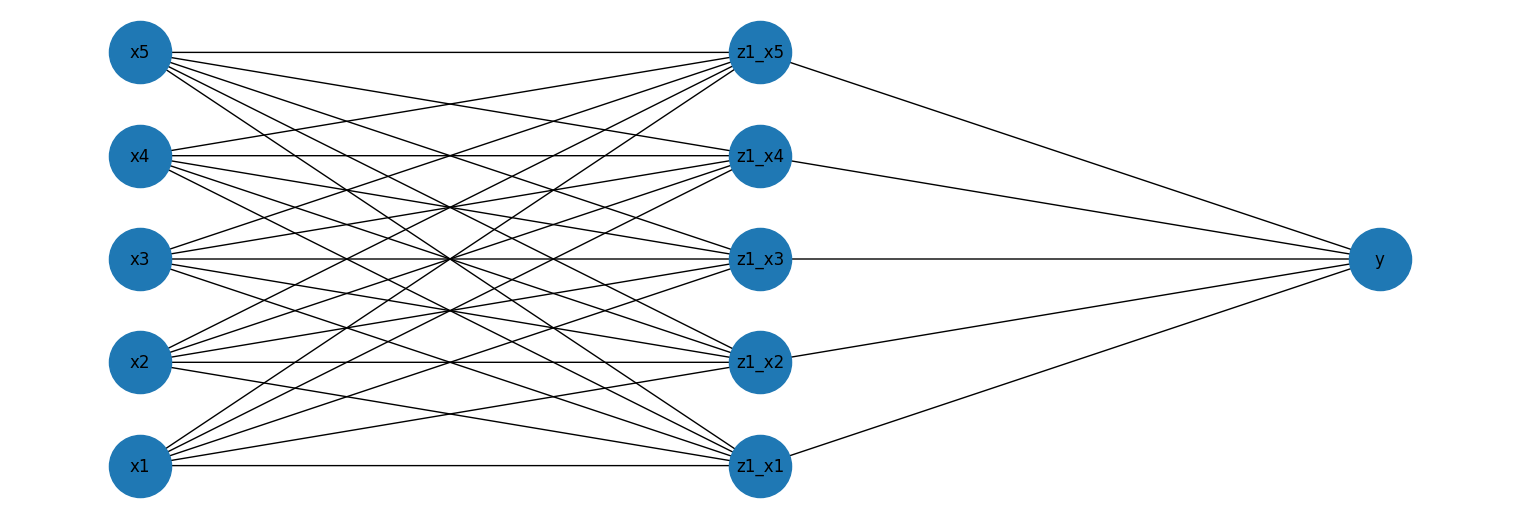

In [311]:
nn = NeuralNet()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
#no border
_ = fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
_ = ax.axis('off')
_ = nn.plot_network_graph(ax)

## Experimentación Manual

100%|██████████| 1000/1000 [00:04<00:00, 214.16it/s]


y_true       27.30000000000000071054
y_pred       38.02447186919267352323
train_loss   97.12084502630682436575
test_loss    77.15170839125075019638
dtype: float64

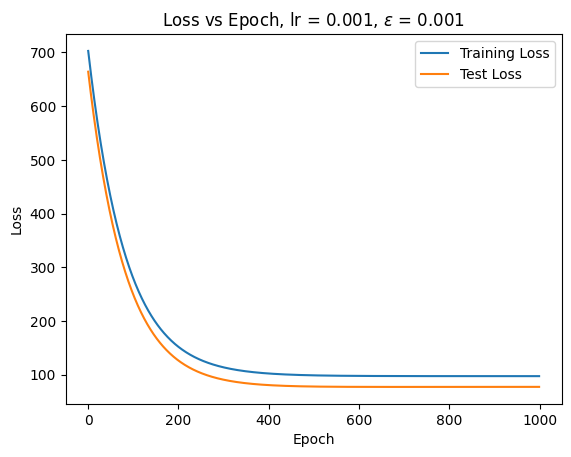

In [312]:
nn = NeuralNet()
nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001, verbose=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0],
        nn.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))
_ = nn.plot_loss()

100%|██████████| 1000/1000 [00:04<00:00, 234.58it/s]


y_true       27.30000000000000071054
y_pred       38.02585324648856612839
train_loss   97.12072752432790423427
test_loss    77.15234065386715656132
dtype: float64

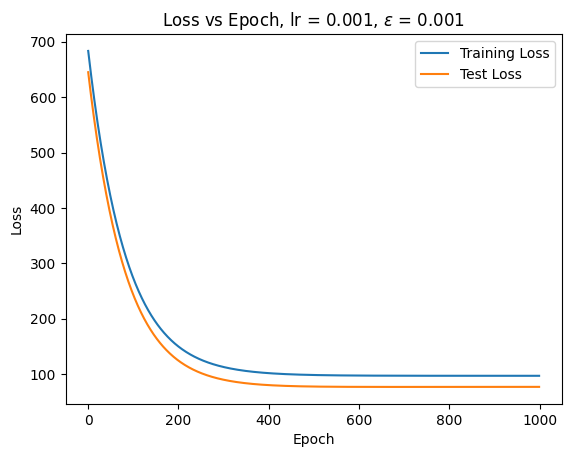

In [313]:
nn = NeuralNet()
nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001, custom_activation=nn.tanh, verbose=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0],
        nn.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))
_ = nn.plot_loss()

100%|██████████| 1000/1000 [00:04<00:00, 220.55it/s]


y_true       27.30000000000000071054
y_pred       27.87010821285398520786
train_loss   52.58049000028180586241
test_loss    35.92346049562767973384
dtype: float64

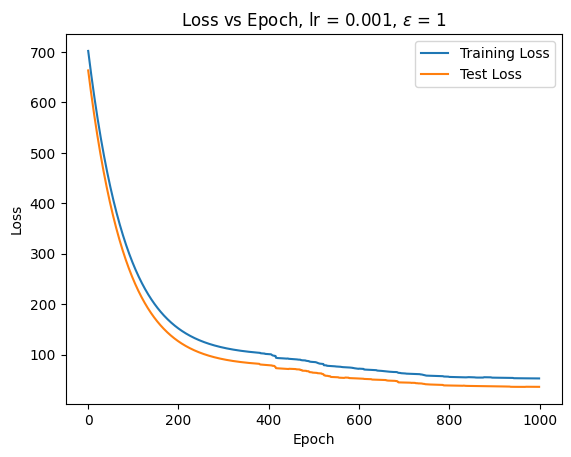

In [305]:
nn = NeuralNet()
nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001, eps=1, verbose=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0],
        nn.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))
_ = nn.plot_loss()

100%|██████████| 1000/1000 [00:04<00:00, 233.20it/s]


y_true       27.30000000000000071054
y_pred       35.42288054345024050917
train_loss   54.96998128619167545139
test_loss    39.69249387913455251464
dtype: float64

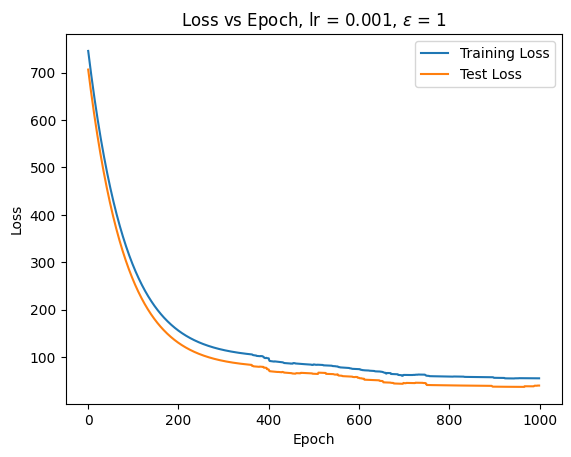

In [304]:
nn = NeuralNet()
nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001, eps=1, custom_activation=nn.tanh, verbose=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0],
        nn.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))
_ = nn.plot_loss()

100%|██████████| 1000/1000 [00:02<00:00, 399.85it/s]


y_true            27.30000000000000071054
y_pred            54.37790898914906279060
train_loss       228.93978918457611371196
test_loss        217.77674017536915584969
min_train_loss    97.11762557642698823201
min_test_loss     77.04854816912815351770
dtype: float64

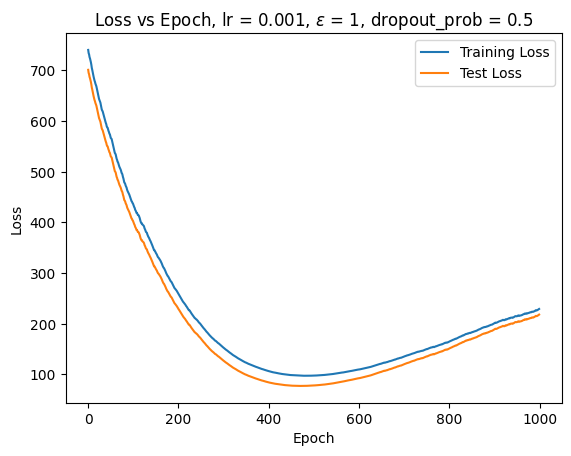

In [309]:
nn_dropout = NeuralNet()
nn_dropout.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001, eps=1, dropout=True, dropout_prob=0.5, verbose=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn_dropout.predict(X_test[0].reshape(1, -1))[0][0],
        nn_dropout.get_training_loss()[-1][0],
        nn_dropout.get_test_loss()[-1][0],
        min(nn_dropout.get_training_loss())[0],
        min(nn_dropout.get_test_loss())[0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss", "min_train_loss", "min_test_loss"]
))
_ = nn_dropout.plot_loss()

100%|██████████| 1000/1000 [00:02<00:00, 461.19it/s]


y_true            27.30000000000000071054
y_pred            54.65448618360453281184
train_loss       233.43453540371953636168
test_loss        222.41958081889217169191
min_train_loss    97.11738405032269838557
min_test_loss     77.04853250241073681082
dtype: float64

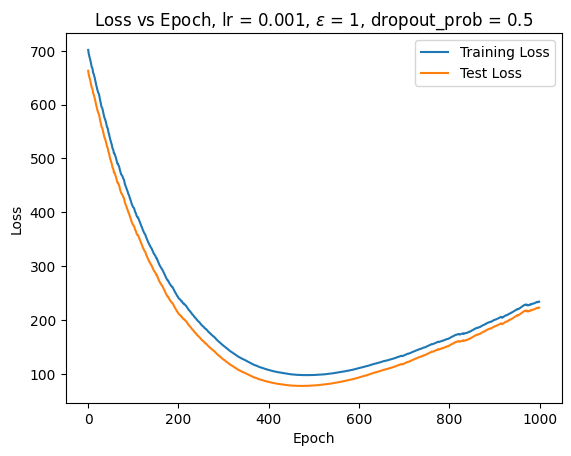

In [310]:
nn_dropout = NeuralNet()
nn_dropout.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001, eps=1, dropout=True, dropout_prob=0.5, custom_activation=nn.tanh, verbose=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn_dropout.predict(X_test[0].reshape(1, -1))[0][0],
        nn_dropout.get_training_loss()[-1][0],
        nn_dropout.get_test_loss()[-1][0],
        min(nn_dropout.get_training_loss())[0],
        min(nn_dropout.get_test_loss())[0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss", "min_train_loss", "min_test_loss"]
))
_ = nn_dropout.plot_loss()

In [301]:
nn_dropout = NeuralNet()
nn_dropout.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=10000, lr=0.001, eps=1, dropout=True, dropout_prob=0.8, verbose=True)

100%|██████████| 10000/10000 [00:38<00:00, 259.49it/s]


[]

In [295]:
display(pd.Series(
    [
        y_test[0][0], 
        nn_dropout.predict(X_test[0].reshape(1, -1))[0][0],
        nn_dropout.get_training_loss()[-1][0],
        nn_dropout.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))

y_true       27.30000000000000071054
y_pred       33.30453404740335798806
train_loss   85.91754731507950282321
test_loss    67.61037497622338321435
dtype: float64

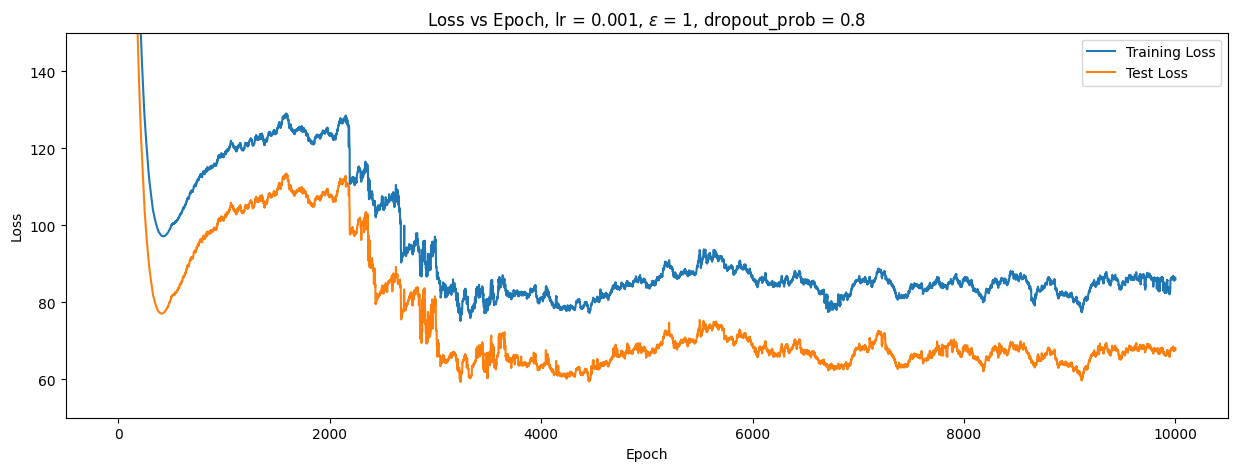

In [297]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set_ylim(50, 150)
_ = nn_dropout.plot_loss(ax=ax)

y_true       27.30000000000000071054
y_pred       37.03763934176618022320
train_loss   97.69831781165335371497
test_loss    77.19354891780324123829
dtype: float64

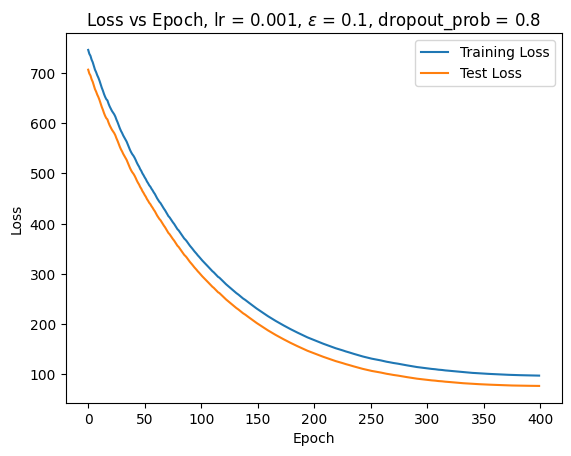

In [298]:
nn_400_dropout = NeuralNet()
nn_400_dropout.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=400, lr=0.001, eps=0.1, dropout=True, dropout_prob=0.8)
display(pd.Series(
    [
        y_test[0][0], 
        nn_400_dropout.predict(X_test[0].reshape(1, -1))[0][0],
        nn_400_dropout.get_training_loss()[-1][0],
        nn_400_dropout.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))
_ = nn_400_dropout.plot_loss()

In [101]:
hyper_nn = NeuralNet()
hyper_nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=50000, lr=0.001, eps=1, dropout=True, dropout_prob=0.8)

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_1661/2190381686.py:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


[]

In [102]:
display(pd.Series(
    [
        y_test[0][0], 
        hyper_nn.predict(X_test[0].reshape(1, -1))[0][0],
        hyper_nn.get_training_loss()[-1][0],
        hyper_nn.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_1661/2190381686.py:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


y_true       27.30000000000000071054
y_pred       28.12064270715838176784
train_loss   96.12452944561505319143
test_loss    79.64967781583217742991
dtype: float64

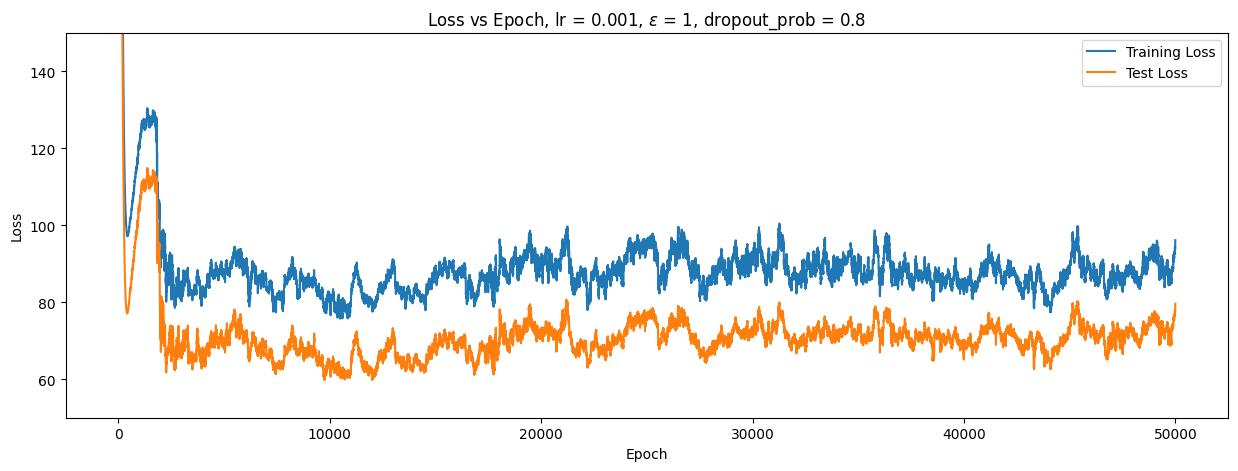

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set_ylim(50, 150)
hyper_nn.plot_loss(ax=ax)

In [104]:
# Epoch en el que se obtuvo la menor Loss

m = min(hyper_nn.get_training_loss(), key=lambda x: x[0])
e = hyper_nn.get_training_loss().index(m)

print(f"Lowest training loss: {m[0]:.2f} at epoch {e}")

Lowest training loss: 75.74 at epoch 10480


In [ ]:
hyper_nn_ = NeuralNet()
hyper_nn_.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=e, lr=0.001, eps=1, dropout=True, dropout_prob=0.8)

## Mascara sobre los pesos: Dropout

Otras dos cuestiones que probamos fueron cambiar la función de activación, y aplicar una mascara a los pesos de entrenamiento de la red con cierta probabilidad en cada epoch.

Para la función de activación probamos con la función sigmoide como indicaba la consigna, y ademas con la funciones ReLU y Tanh.

$$
\text{ReLU}(x) = \max(0, x) \\
\text{Tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$


y_true        27.30000000000000071054
y_pred        57.63734020134181434969
train_loss   287.87181630280230137942
dtype: float64

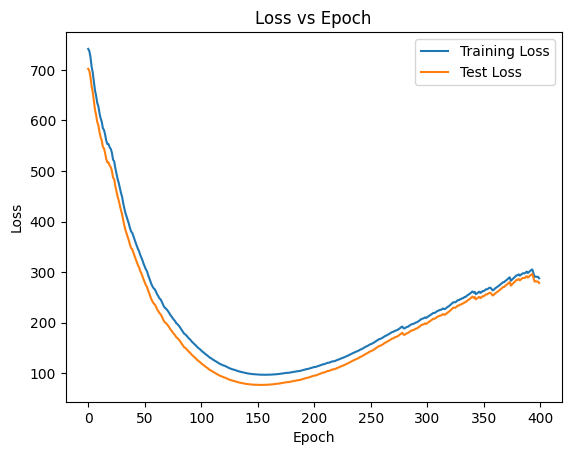

In [130]:
nn = NeuralNet()
loss = nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.003, epochs=400, dropout=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0]
    ], 
    index=["y_true", "y_pred", "train_loss"]
))
nn.plot_loss()

y_true        27.30000000000000071054
y_pred        46.12380957676615622631
train_loss   107.23579872377744948153
dtype: float64

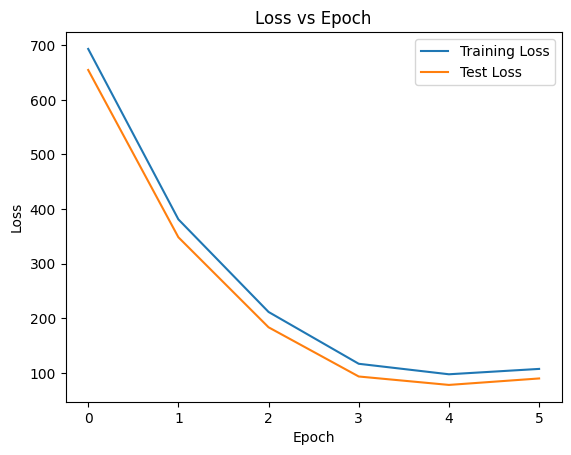

In [17]:
nn = NeuralNet()
loss = nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.1, epochs=6, dropout=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0]
    ], 
    index=["y_true", "y_pred", "train_loss"]
))
nn.plot_loss()

y_true        27.30000000000000071054
y_pred        38.24117112246570826528
train_loss   103.20305378438199284119
dtype: float64

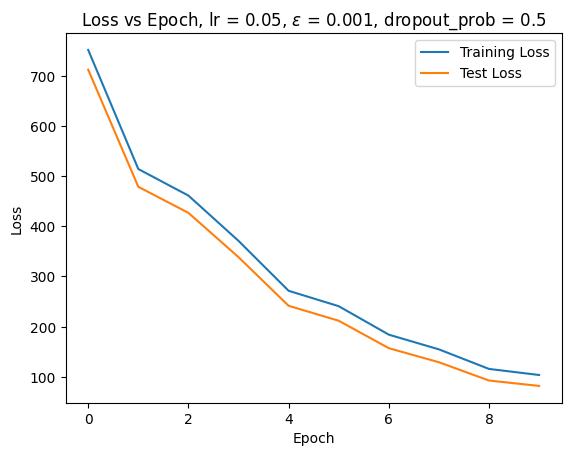

In [243]:
nn = NeuralNet()
loss = nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.05, epochs=10, dropout=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0]
    ], 
    index=["y_true", "y_pred", "train_loss"]
))
nn.plot_loss()

## Otras funciones de activación

Para la función de activación probamos con la función sigmoide como indicaba la consigna, y ademas con la funciones ReLU, Leaky Relu y Tanh.

$$
\text{ReLU}(x) = \max(0, x) \\
\text{LeakyReLU}(x) = \max(0.01x, x) \\
\text{Tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

### ReLu y Leaky ReLu

Con las función ReLU y Leaky ReLU no logramos convergencia.

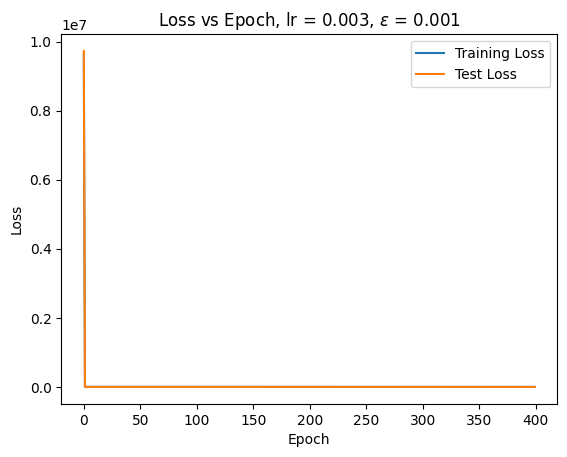

In [373]:
nn_relu = NeuralNet()
nn_relu.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.003, epochs=400, custom_activation=nn.relu)
_ = nn_relu.plot_loss()

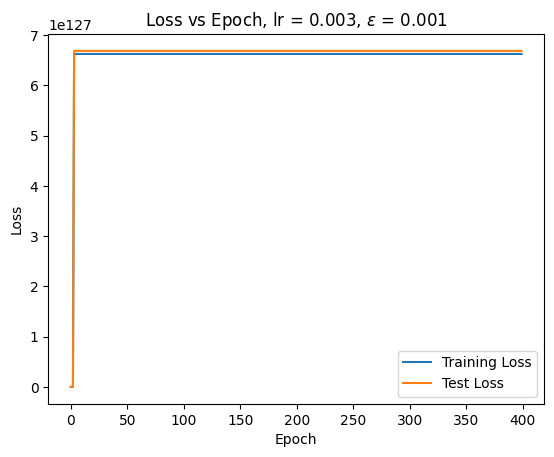

In [372]:
nn_leaky = NeuralNet()
nn_leaky.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.003, epochs=400, custom_activation=nn.leaky_relu)
_ = nn_leaky.plot_loss()

Sin Embargo para la función Tanh si vimos convergencia en nuestras pruebas.

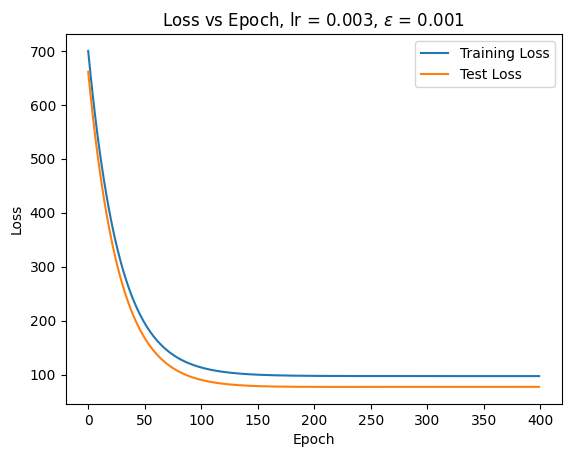

In [249]:
nn_tanh = NeuralNet()
nn_tanh.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.003, epochs=400, custom_activation=nn.tanh)
nn_tanh.plot_loss()

Aca una comparación entre las funciones de activación sigmoide y tanh.
En este caso la función de activación tanh hasta converge mas rápido y a una loss menor que la sigmoide.

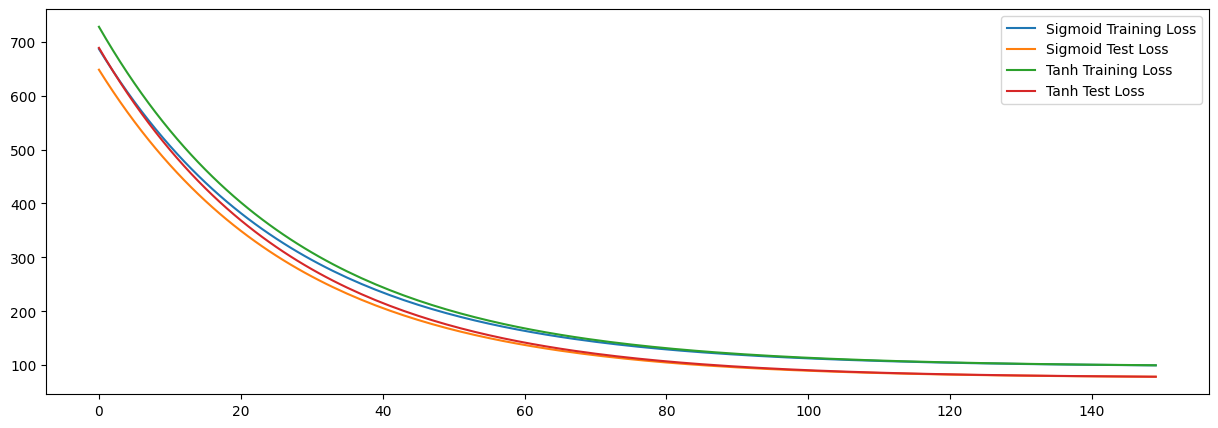

In [250]:
fig, ax = plt.subplots(figsize=(15, 5))

nn = NeuralNet()
nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.003, epochs=150)

nn_tanh = NeuralNet()
nn_tanh.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.003, epochs=150, custom_activation=nn.tanh)

ax.plot(nn.get_training_loss(), label="Sigmoid Training Loss")
ax.plot(nn.get_test_loss(), label="Sigmoid Test Loss")

ax.plot(nn_tanh.get_training_loss(), label="Tanh Training Loss")
ax.plot(nn_tanh.get_test_loss(), label="Tanh Test Loss")
ax.legend()

## Distintos valores de Learning Rate para distintos Epochs

In [151]:
# Brute force para encontrar el mejor número de epochs y learning rate

lrs = np.linspace(0.001, 0.5, 10).round(3)
eps = list(range(1, 1000, 50))

train_losses = {}
test_losses = {}

for lr, ep in tqdm(list(itertools.product(lrs, eps))):
    nn = NeuralNet()
    nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=lr, epochs=int(ep))
    
    train_losses[(lr, int(ep))] = nn.get_training_loss()[-1][0]
    test_losses[(lr, int(ep))] = nn.get_test_loss()[-1][0]

100%|██████████| 200/200 [06:15<00:00,  1.88s/it]


In [154]:
train_losses_arr = []
test_losses_arr = []

for (lr, ep), loss in train_losses.items():
    train_losses_arr.append((lr, int(ep), loss))

for (lr, ep), loss in test_losses.items():
    test_losses_arr.append((lr, int(ep), loss))

train_losses_df = pd.DataFrame(train_losses_arr, columns=['lr', 'epochs', 'loss'])
test_losses_df = pd.DataFrame(test_losses_arr, columns=['lr', 'epochs', 'loss'])

# merge dataframes
losses_df = pd.merge(train_losses_df, test_losses_df, on=['lr', 'epochs'], suffixes=('_train', '_test'))
losses_df

lr  epochs  \
0   0.00100000000000000002       1   
1   0.00100000000000000002      51   
2   0.00100000000000000002     101   
3   0.00100000000000000002     151   
4   0.00100000000000000002     201   
..                     ...     ...   
195 0.50000000000000000000     751   
196 0.50000000000000000000     801   
197 0.50000000000000000000     851   
198 0.50000000000000000000     901   
199 0.50000000000000000000     951   

                                            loss_train  \
0                             712.35544408202019894816   
1                             438.10390531169031191894   
2                             277.70827155145241249556   
3                             204.45153606491405184897   
4                             152.95659639606813584578   
..                                                 ...   
195 10,064,873,608,080,629,039,315,616,564,842,070,...   
196 38,883,928,850,905,498,030,357,258,510,008,320....   
197 1,964,394,829,934,937,164,113,258,741,760.00000...   
198 161,643,292,004,524,220,750,446,944,777,003,859...   
199 5,408,037,911,253,026,769,260,384,748,568,576.0...   

                                             loss_test  
0                             673.50730859418263207772  
1                             404.09167713681171107964  
2                             247.53186235583663687976  
3                             176.62372830443592874872  
4                             127.33201401750525860734  
..                                                 ...  
195 10,064,873,608,080,626,678,132,375,130,019,463,...  
196 38,883,928,850,905,493,418,671,240,082,620,416....  
197 1,964,394,829,934,938,571,488,142,295,040.00000...  
198 161,643,292,004,524,220,750,446,944,777,003,859...  
199 5,408,037,911,253,026,769,260,384,748,568,576.0...  

[200 rows x 4 columns]

In [160]:
losses_df.sort_values(by='loss_test', ascending=True).head(10)

lr  epochs              loss_train  \
14  0.00100000000000000002     701 97.24997849157063001257   
13  0.00100000000000000002     651 97.36517063828993912011   
15  0.00100000000000000002     751 97.18700042019692375561   
16  0.00100000000000000002     801 97.15765470153172600476   
17  0.00100000000000000002     851 97.13886442836047763194   
12  0.00100000000000000002     601 97.53729094639008678769   
18  0.00100000000000000002     901 97.12979841319094020946   
19  0.00100000000000000002     951 97.12443781084131444459   
148 0.38900000000000001243     401 97.11721857464502249968   
182 0.50000000000000000000     101 97.11721191618177329019   

                  loss_test  
14  77.04882381592535978143  
13  77.06209465460953822458  
15  77.06229356767643423609  
16  77.08106987569057366727  
17  77.10344679716750704301  
12  77.11963007880184761689  
18  77.12105310560889392946  
19  77.13643326268517341759  
148 77.19205646245166008157  
182 77.19363039787369018541

In [161]:
losses_df.sort_values(by='loss_train', ascending=True).head(10)

lr  epochs              loss_train  \
81  0.22300000000000000377      51 97.11721158982109614044   
98  0.22300000000000000377     901 97.11721158982109614044   
118 0.27800000000000002487     901 97.11721158982109614044   
26  0.05600000000000000117     301 97.11721158982109614044   
95  0.22300000000000000377     751 97.11721158982109614044   
45  0.11200000000000000233     251 97.11721158982109614044   
42  0.11200000000000000233     101 97.11721158982109614044   
44  0.11200000000000000233     201 97.11721158982109614044   
28  0.05600000000000000117     401 97.11721158982109614044   
71  0.16700000000000000955     551 97.11721158982109614044   

                  loss_test  
81  77.19406594744638994143  
98  77.19406594746409666641  
118 77.19406594745940708435  
26  77.19406594745862548734  
95  77.19406594745851180051  
45  77.19406594745805705315  
42  77.19406594745773020350  
44  77.19406594745751704068  
28  77.19406594745743177555  
71  77.19406594745981919914

Muchos de los valores de lr convergen a la misma loss minima ~(97.117), pero algunos lo hacen mas rapido que otros. En nuestra experimentación con el Learning Rate, obtuvimos que para lr=0.05 y epoch=20, la Loss alcanzaba ~(97.118).

En estos gráficos de calor podemos ver como la mayoría de los learning rates para cierto epoch logran converger a este mismo valor.

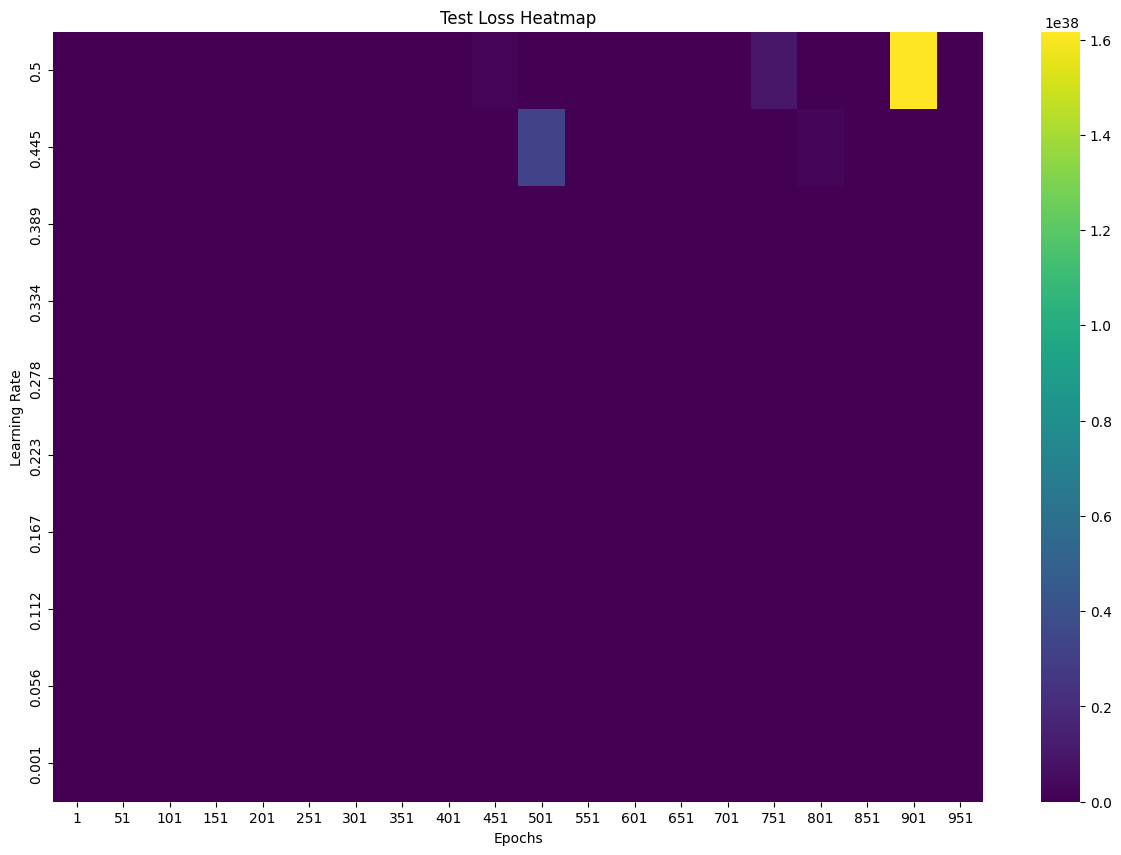

In [163]:
losses_df_hm = losses_df.pivot(index='lr', columns='epochs', values='loss_test')

fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(losses_df_hm, ax=ax, cmap='viridis')
ax.set_xlabel('Epochs')
ax.set_ylabel('Learning Rate')
ax.set_title('Test Loss Heatmap')
ax.invert_yaxis()
plt.show()

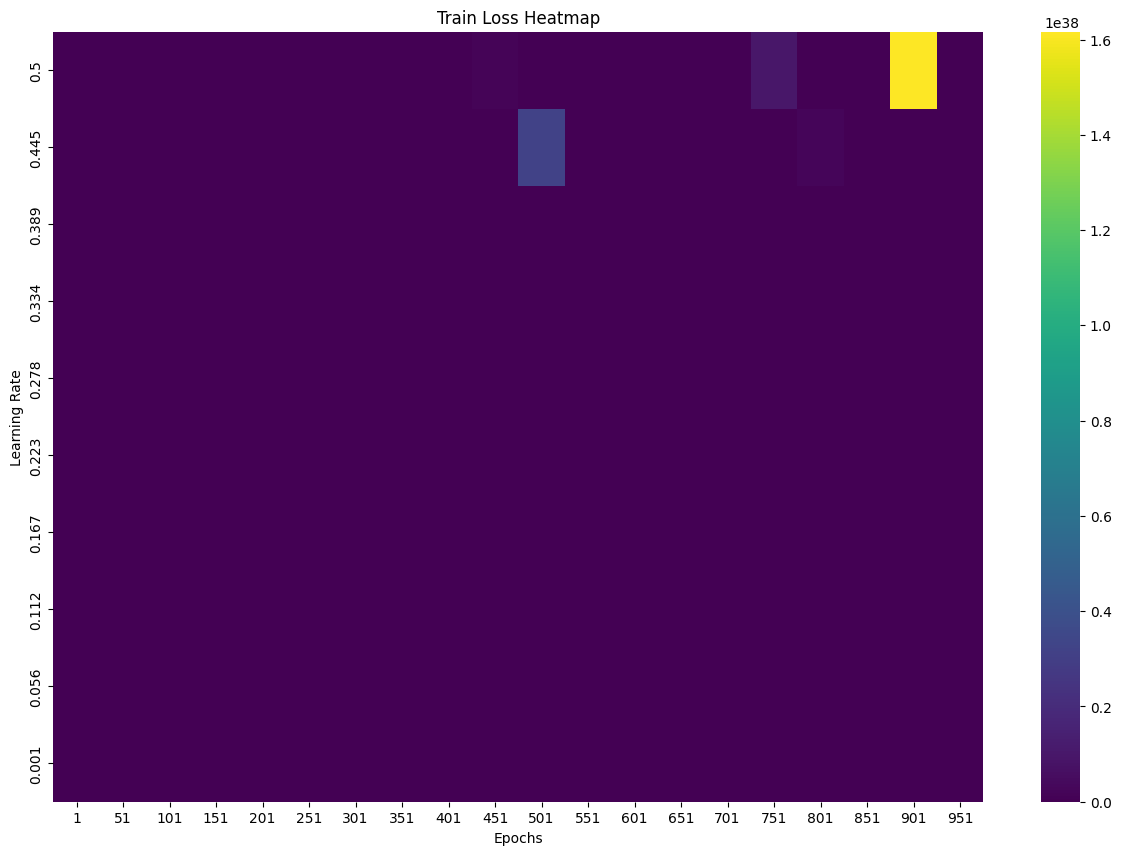

In [164]:
losses_df_hm = losses_df.pivot(index='lr', columns='epochs', values='loss_train')

fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(losses_df_hm, ax=ax, cmap='viridis')
ax.set_xlabel('Epochs')
ax.set_ylabel('Learning Rate')
ax.set_title('Train Loss Heatmap')
ax.invert_yaxis()
plt.show()

Para lograr obtener una menor Loss, probamos modificando el valor de Epsilon

y_true       27.30000000000000071054
y_pred       28.85025195570380773802
train_loss   53.80364135528142099929
dtype: float64

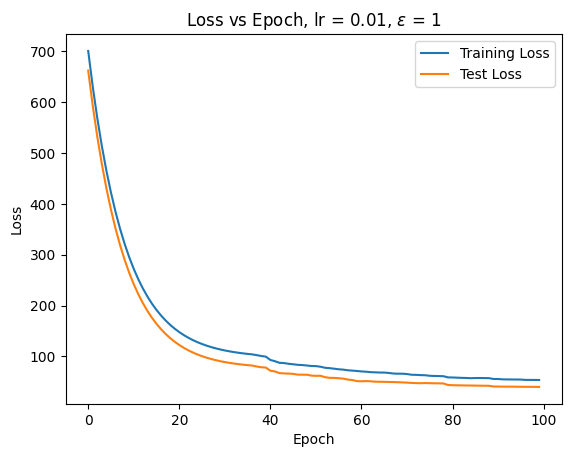

In [206]:
nn = NeuralNet()
loss = nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.01, epochs=100, eps=1)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0]
    ], 
    index=["y_true", "y_pred", "train_loss"]
))
nn.plot_loss()

## Combinaciones de Learning Rate y Epsilon

Buscamos ver como variando el Epsilon junto al Learning Rate para una cantidad fija arbitraria de epochs podemos encontrar un valor de lr que converja mas rápido sobre los modelos con las funciones de activación Tanh y Sigmoide, esta última con y sin Dropout de pesos. Ademas, vamos a ver como cambia la loss minima para cuando finalice el entrenamiento.

In [114]:
# Brute force, best learning rate, epsilons, with and without dropout

lrs = np.linspace(0.001, 0.5, 10).round(3)
#epochs = list(range(0, 1050, 50))[1:]
epochs = [500] # Se podría probar con distintos epochs, idealmente valores mayores, los anteriores se pueden obtener como "early stops"
epsilons = list(map(lambda x: x/10000, range(0, 10005, 500)[1:]))

In [186]:
len(epsilons), len(lrs), len(epochs)

(20, 10, 1)

In [187]:
len(list(itertools.product(lrs, epochs, epsilons)))

200

In [123]:
losses = {
    'default': {
        'train': {},
        'test': {}
    },
    'tanh': {
        'train': {},
        'test': {}
    },
    'dropout': {
        'train': {},
        'test': {}
    },
}

In [146]:
for lr, ep, eps in tqdm(list(itertools.product(lrs, epochs, epsilons))):

    nn = NeuralNet()
    nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=lr, epochs=int(ep), eps=eps)
    losses['default']['train'][lr, ep, eps] = nn.get_training_loss()
    losses['default']['test'][lr, ep, eps] = nn.get_test_loss()

    nn_drop = NeuralNet()
    nn_drop.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=lr, epochs=int(ep), eps=eps, dropout=True)
    losses['dropout']['train'][lr, ep, eps] = nn_drop.get_training_loss()
    losses['dropout']['test'][lr, ep, eps] = nn_drop.get_test_loss()

    nn_tanh = NeuralNet()
    nn_tanh.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=lr, epochs=int(ep), eps=eps, custom_activation=nn_tanh.tanh)
    losses['tanh']['train'][lr, ep, eps] = nn_tanh.get_training_loss()
    losses['tanh']['test'][lr, ep, eps] = nn_tanh.get_test_loss()

  1%|          | 2/200 [00:10<17:29,  5.30s/it]/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_64997/343068776.py:30: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 200/200 [17:34<00:00,  5.27s/it]


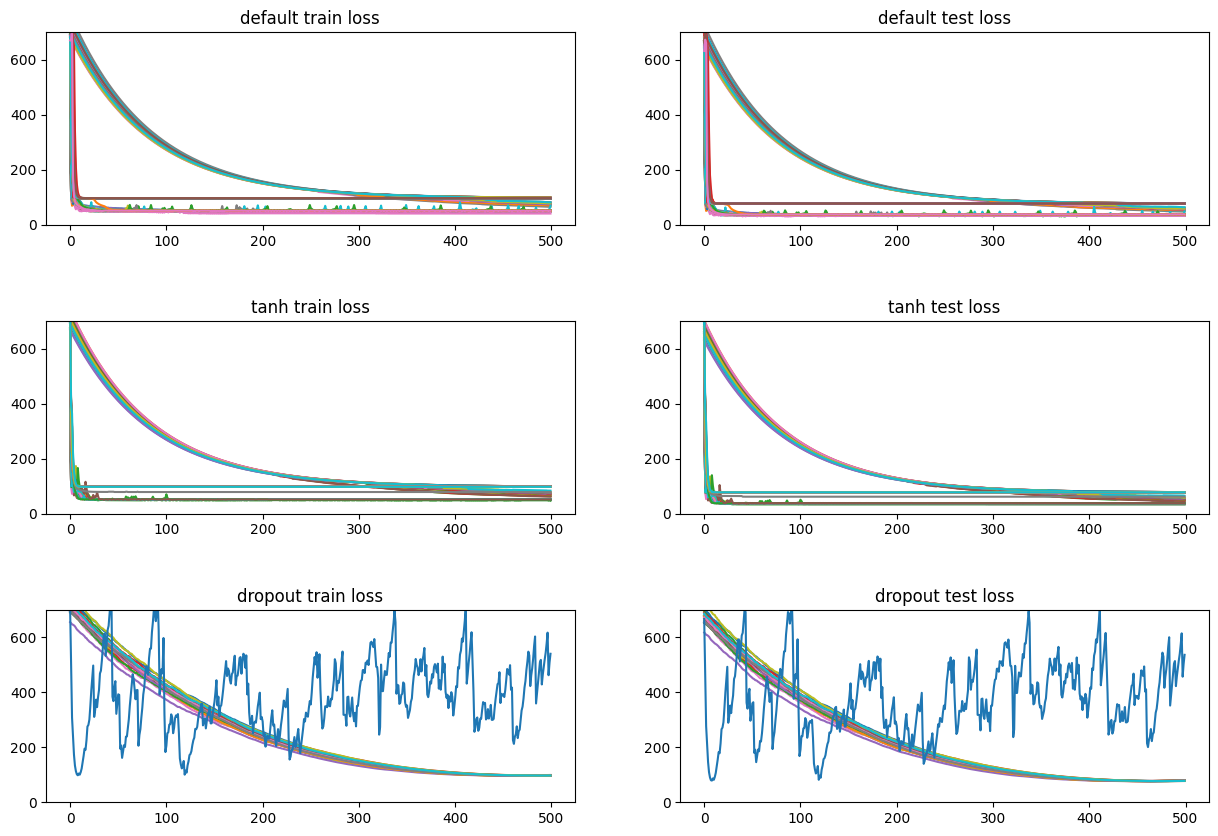

In [207]:
fig, axs = plt.subplots(len(losses.keys()), 2, figsize=(15, 10))

for i, (variation, train_test) in enumerate(losses.items()):
    for (lr, ep, eps), loss in train_test['train'].items():
        # De forma empírica observamos que con pesos aleatorios, la loss comienza al rededor de ~700
        # Evitamos en el gráfico aquellos que superen en algún momento esa loss para limpiar
        if any([l > 800 for l in loss]):
            continue
        axs[i, 0].plot(loss, label=f'lr={lr}, ep={ep}, eps={eps}')
    
    for (lr, ep, eps), loss in train_test['test'].items():
        if any([l > 800 for l in loss]):
            continue
        axs[i, 1].plot(loss, label=f'lr={lr}, ep={ep}, eps={eps}')

    axs[i, 0].set_title(f'{variation} train loss')
    axs[i, 1].set_title(f'{variation} test loss')

    axs[i, 0].set_ylim(0, 700)
    axs[i, 1].set_ylim(0, 700)

# Add space between subplots
fig.subplots_adjust(hspace=0.5)


Podemos observar como para ciertas combinaciones de Learning Rate y Epochs la convergencia es mas rápida.

Para la función de activación ReLU observamos que la convergencía no ocurre directamente por lo que se dejo de evaluar, la función Tanh sin embargo si converge, pero no logra alcanzar la misma loss minima que la función sigmoide.

Para la mascara de pesos, probamos con una probabilidad de 0.5. En todos los casos la convergencia fue o mas lenta, y la loss minima alcanzada mayor que la obtenida sin aplicar la mascara, o directamente esporádico sin convergencia.

(0.0, 700.0)

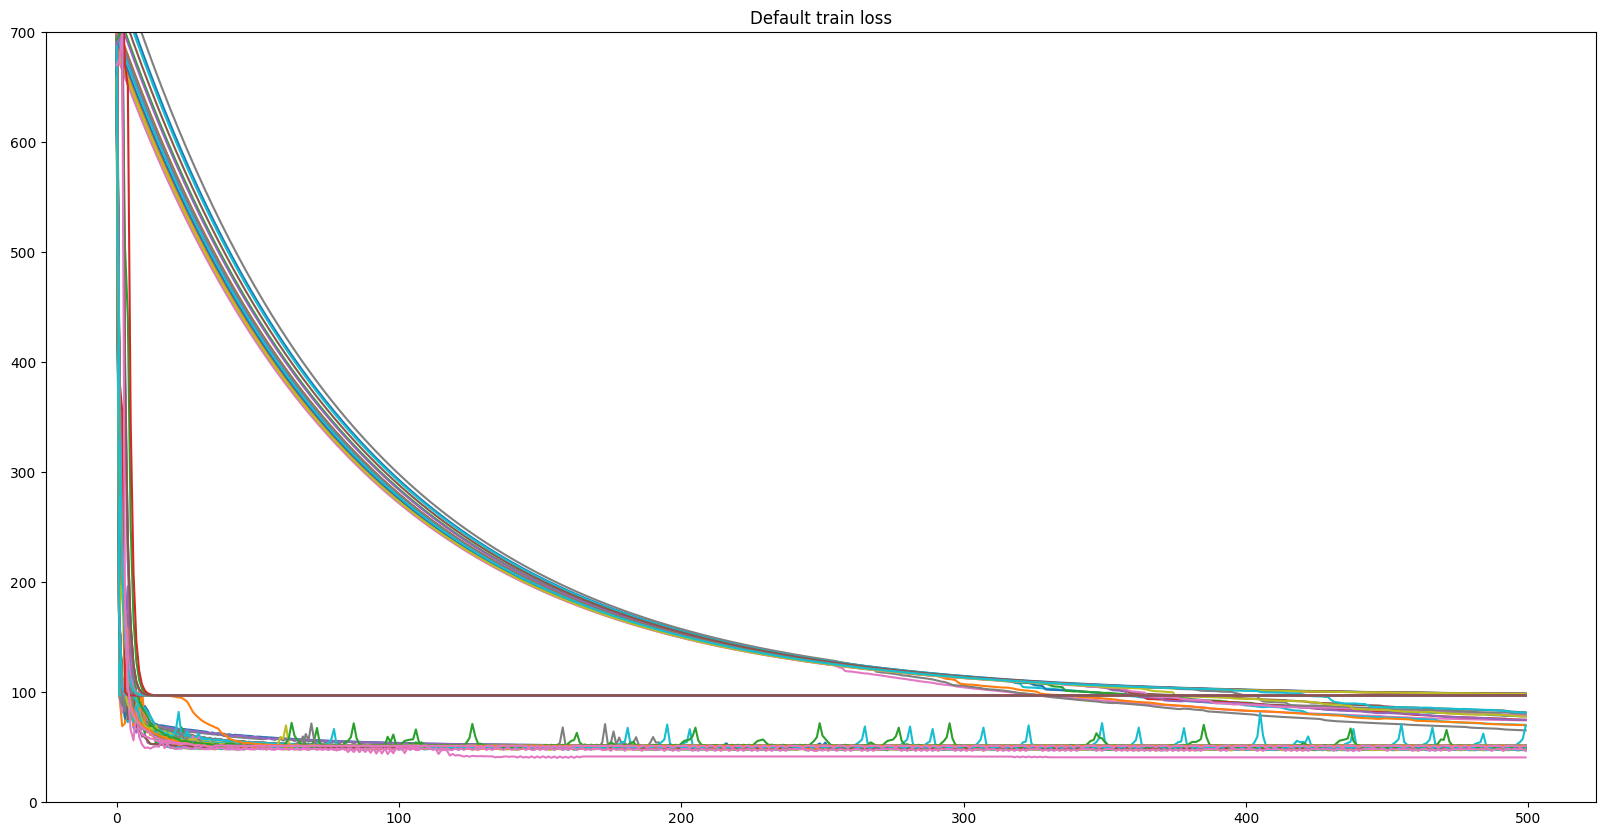

In [215]:
# Large Default Training Loss Plot
fig, ax = plt.subplots(figsize=(20, 10))

for (lr, ep, eps), loss in losses['default']['train'].items():
    
    if any([l > 800 for l in loss]):
        continue
    ax.plot(loss, label=f'lr={lr}, ep={ep}, eps={eps}')

ax.set_title(f'Default train loss')
#ax.legend()

ax.set_ylim(0, 700)

(40.0, 120.0)

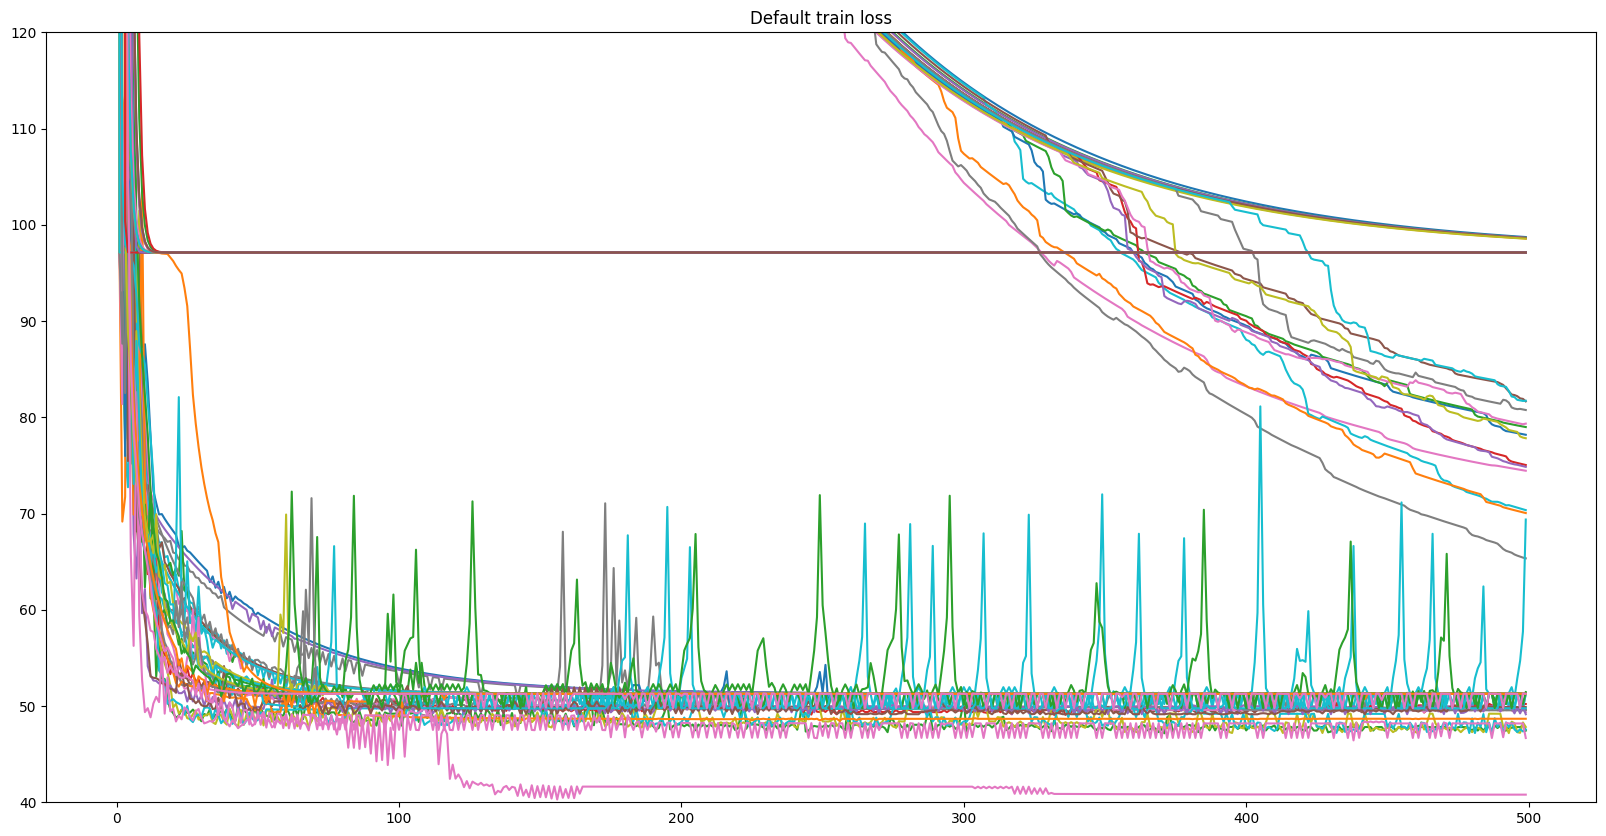

In [211]:
# Large Default Training Loss Plot
fig, ax = plt.subplots(figsize=(20, 10))

for (lr, ep, eps), loss in losses['default']['train'].items():
    if any([l > 800 for l in loss]):
        continue
    ax.plot(loss, label=f'lr={lr}, ep={ep}, eps={eps}')

ax.set_title(f'Default train loss')
ax.set_ylim(40, 120)

(30.0, 80.0)

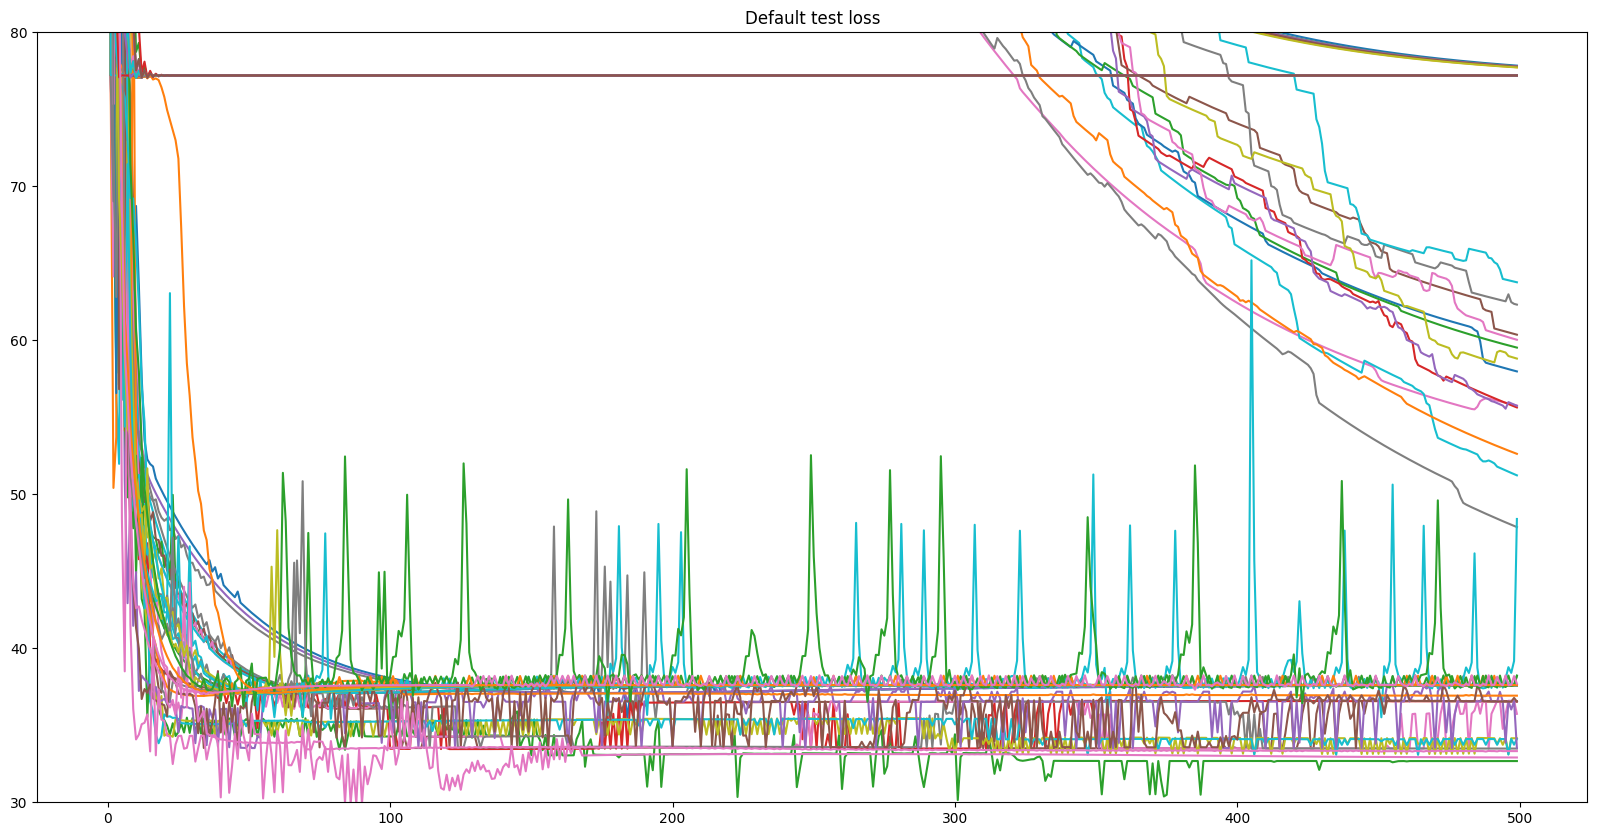

In [212]:
# Large Default Test Loss Plot
fig, ax = plt.subplots(figsize=(20, 10))

for (lr, ep, eps), loss in losses['default']['test'].items():
    if any([l > 800 for l in loss]):
        continue
    ax.plot(loss, label=f'lr={lr}, ep={ep}, eps={eps}')

ax.set_title(f'Default test loss')
ax.set_ylim(30, 80)

(40.0, 120.0)

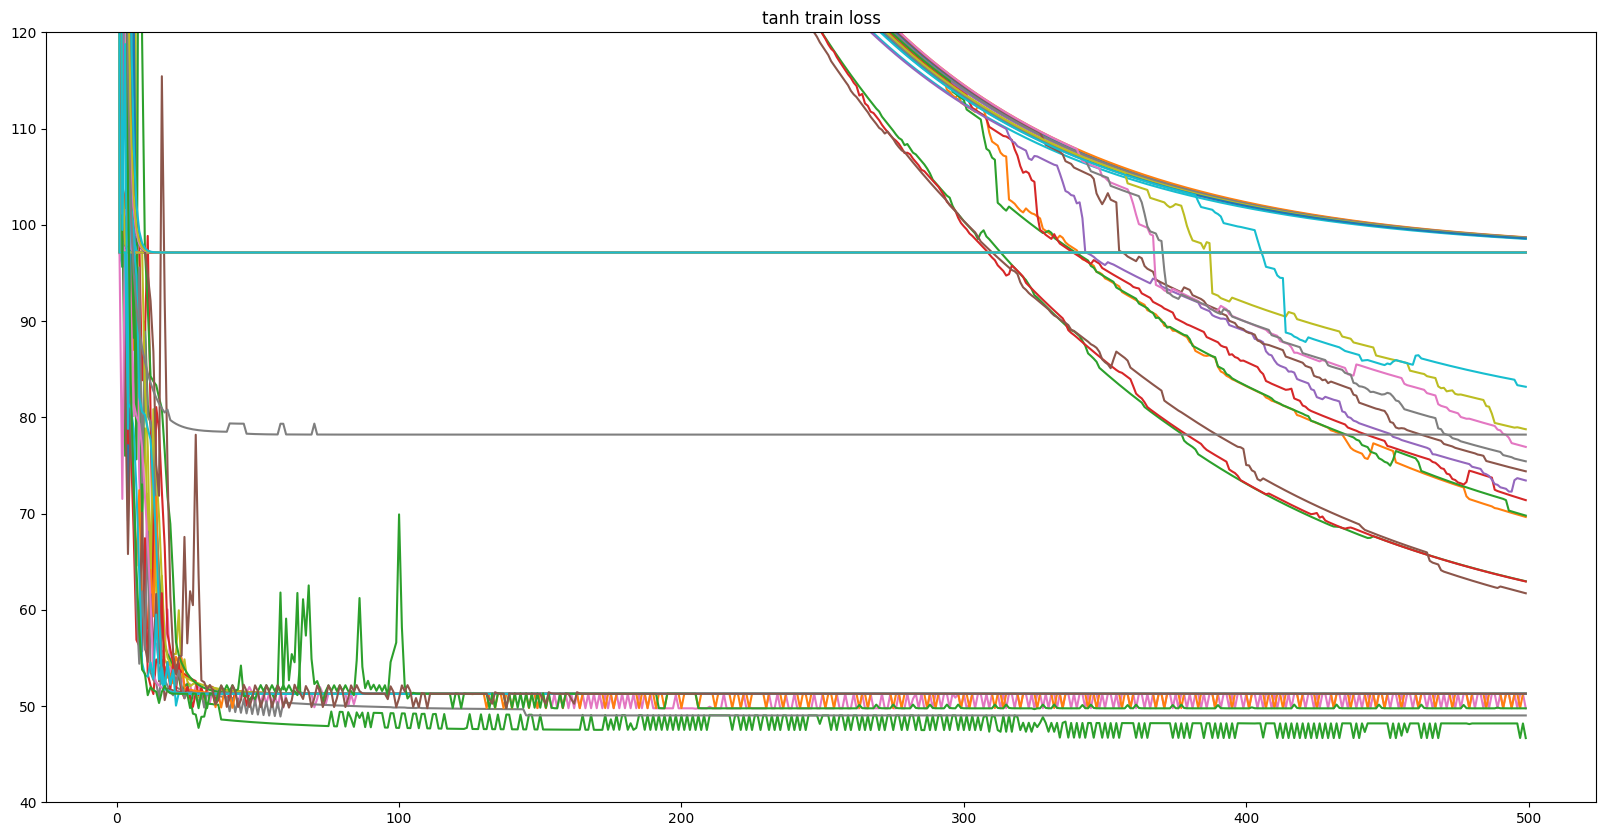

In [213]:
# Large Default Training Loss Plot
fig, ax = plt.subplots(figsize=(20, 10))

for (lr, ep, eps), loss in losses['tanh']['train'].items():
    if any([l > 800 for l in loss]):
        continue
    ax.plot(loss, label=f'lr={lr}, ep={ep}, eps={eps}')

ax.set_title(f'tanh train loss')
ax.set_ylim(40, 120)

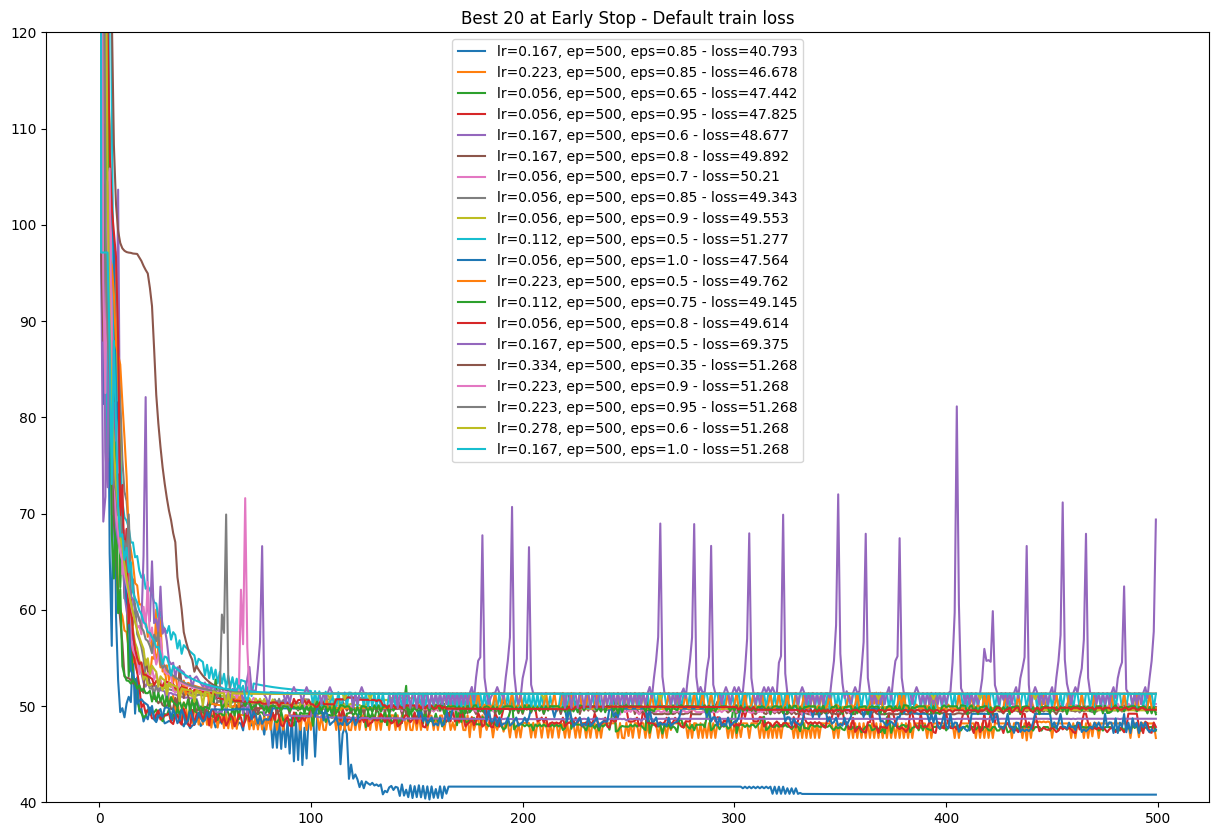

In [171]:
# Filter out the best learning rate - epsilons combinations for the Default NN
# The 20 lowest training loss by epoch 200

# Sort by the loss at epoch 250

train_loss = losses['default']['train'].items()

train_loss = sorted(train_loss, key=lambda x: x[1][250])

# Plot every train_loss[:20]

fig, ax = plt.subplots(figsize=(15, 10))
 
for (lr, ep, eps), loss in train_loss[:20]:
    ax.plot(loss, label=f'lr={lr}, ep={ep}, eps={eps} - loss={loss[-1].round(3)[0]}')

ax.set_title(f'Best 20 at Early Stop - Default train loss')
ax.set_ylim(40, 120)
ax.legend()

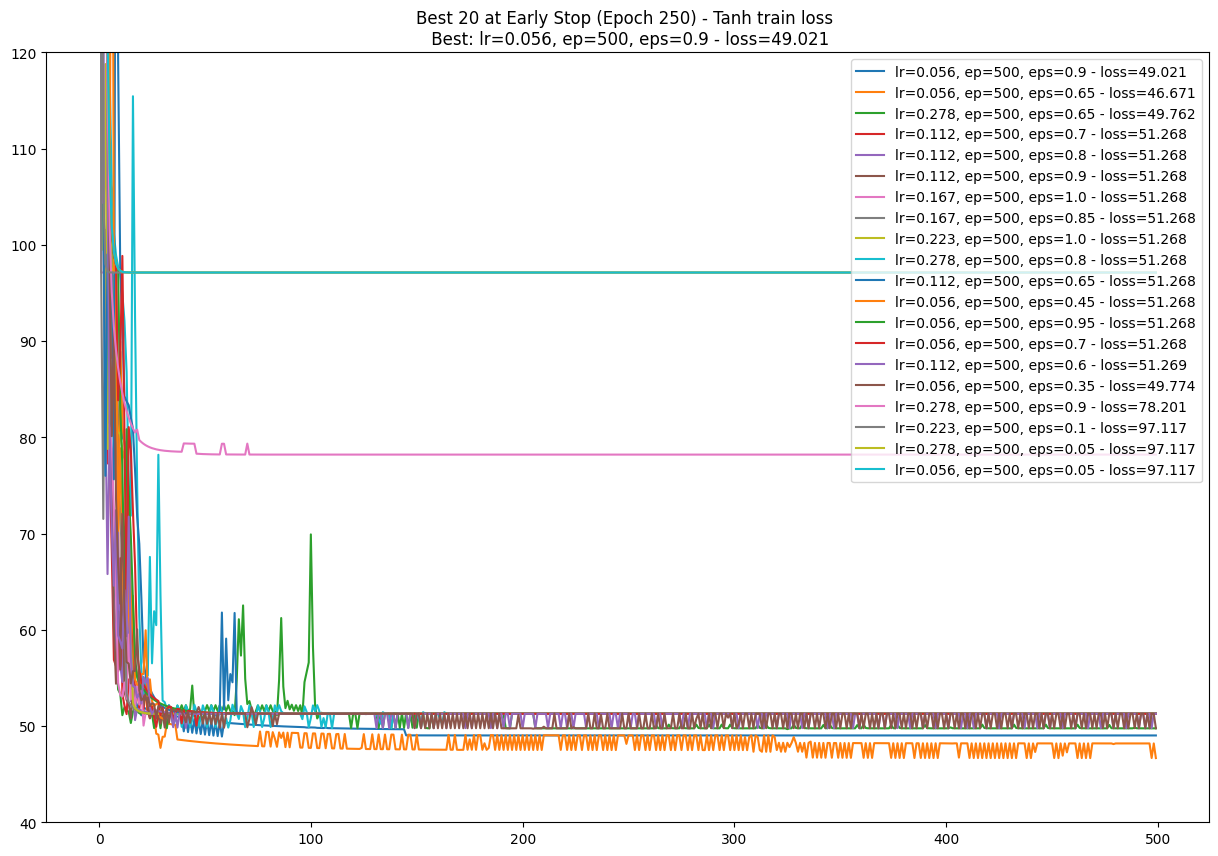

In [197]:
# Filter out the best learning rate - epsilons combinations for the Default NN
# The 20 lowest training loss by epoch 200

# Sort by the loss at epoch 250

train_loss = losses['tanh']['train'].items()

train_loss = sorted(train_loss, key=lambda x: x[1][250])

# Plot every train_loss[:20]

fig, ax = plt.subplots(figsize=(15, 10))
 
for (lr, ep, eps), loss in train_loss[:20]:
    ax.plot(loss, label=f'lr={lr}, ep={ep}, eps={eps} - loss={loss[-1].round(3)[0]}')

(min_250_lr, min_250_ep, min_250_eps), min_250_loss = train_loss[0]

ax.set_title(f'Best 20 at Early Stop (Epoch 250) - Tanh train loss \n Best: lr={min_250_lr}, ep={min_250_ep}, eps={min_250_eps} - loss={min_250_loss[-1].round(3)[0]}')
ax.set_ylim(40, 120)
ax.legend()

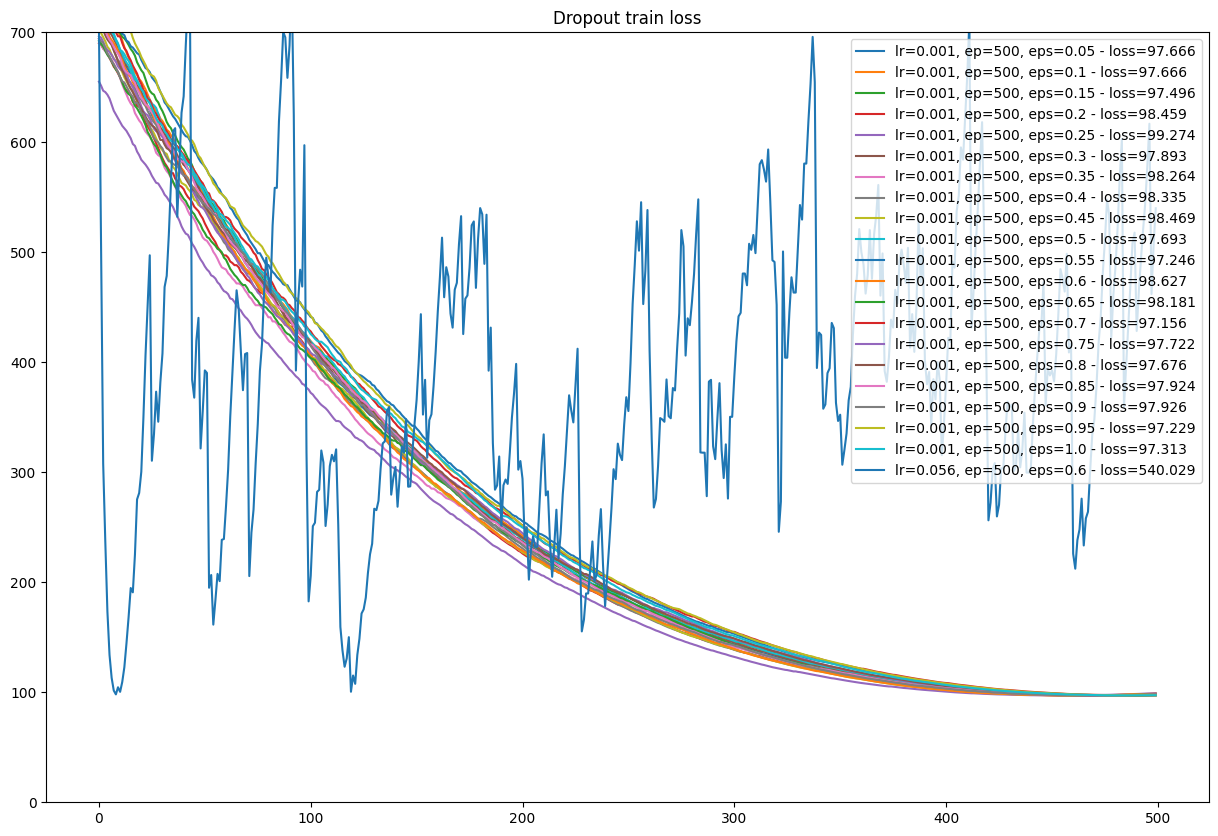

In [172]:
# Large Dropout Training Loss Plot

fig, ax = plt.subplots(figsize=(15, 10))

for (lr, ep, eps), loss in losses['dropout']['train'].items():
    
    # If loss has any value > 800, skip
    if any([l > 800 for l in loss]):
        continue

    ax.plot(loss, label=f'lr={lr}, ep={ep}, eps={eps} - loss={loss[-1].round(3)[0]}')

ax.set_title(f'Dropout train loss')
ax.set_ylim(0, 700)
ax.legend()


(0.0, 100.0)

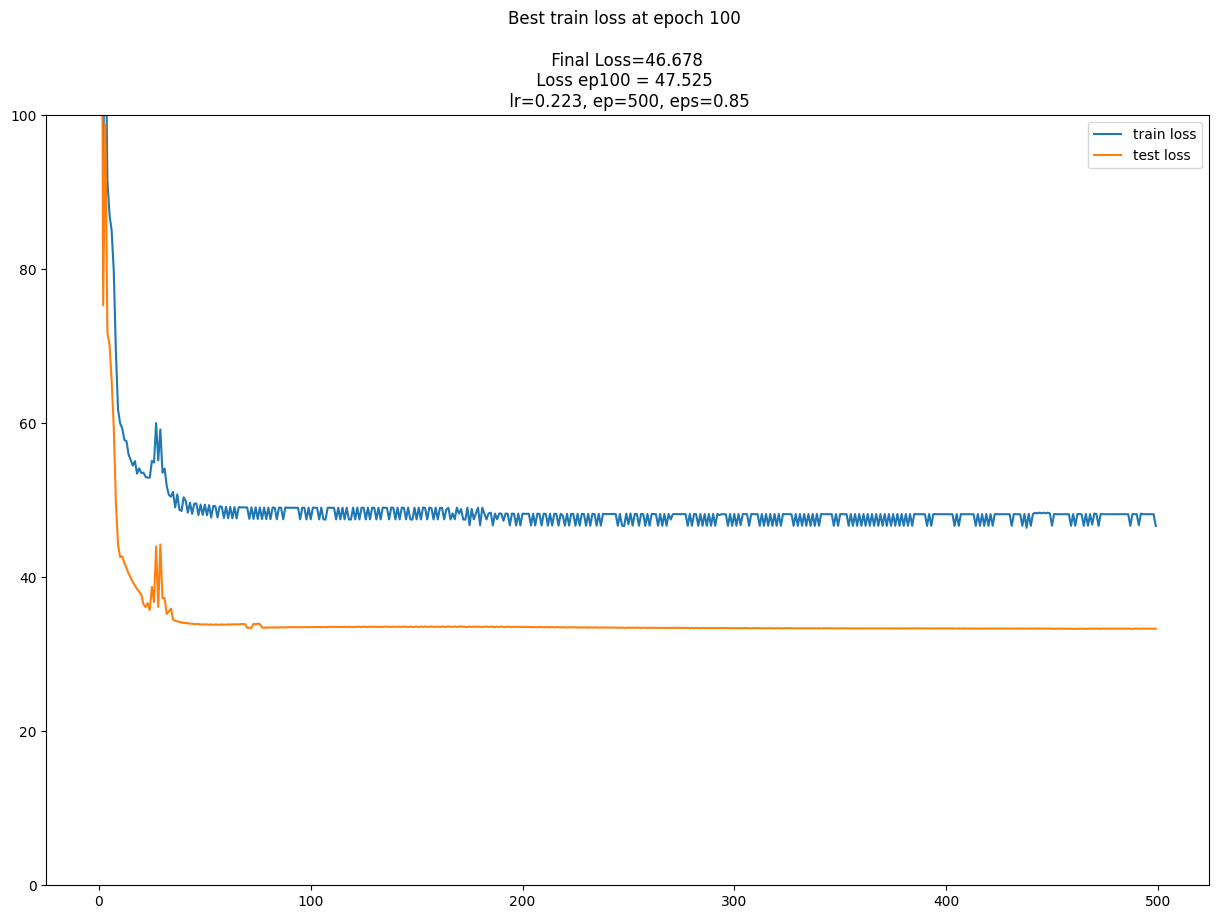

In [198]:
# Min loss for default at epoch 100

(min_lr, min_ep, min_eps), min_train_loss = min(losses['default']['train'].items(), key=lambda x: x[1][100])
min_test_loss = losses['default']['test'][(min_lr, min_ep, min_eps)]

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(min_train_loss, label=f'train loss')
ax.plot(min_test_loss, label=f'test loss')

ax.set_title(f'Best train loss at epoch 100 \n\n Final Loss={min_train_loss[-1].round(3)[0]} \n Loss ep100 = {min_train_loss[100].round(3)[0]}  \n lr={min_lr}, ep={min_ep}, eps={min_eps}')

ax.legend()

ax.set_ylim(0, 100)

In [219]:
# Filter dropout losses, if any > 800

less_dropout_train_loss = {}
less_dropout_test_loss = {}

for (lr, ep, eps), loss in losses['dropout']['train'].items():
    if any([l > 800 for l in loss]):
        continue
    less_dropout_train_loss[(lr, ep, eps)] = loss
    less_dropout_test_loss[(lr, ep, eps)] = losses['dropout']['test'][(lr, ep, eps)]

(0.0, 140.0)

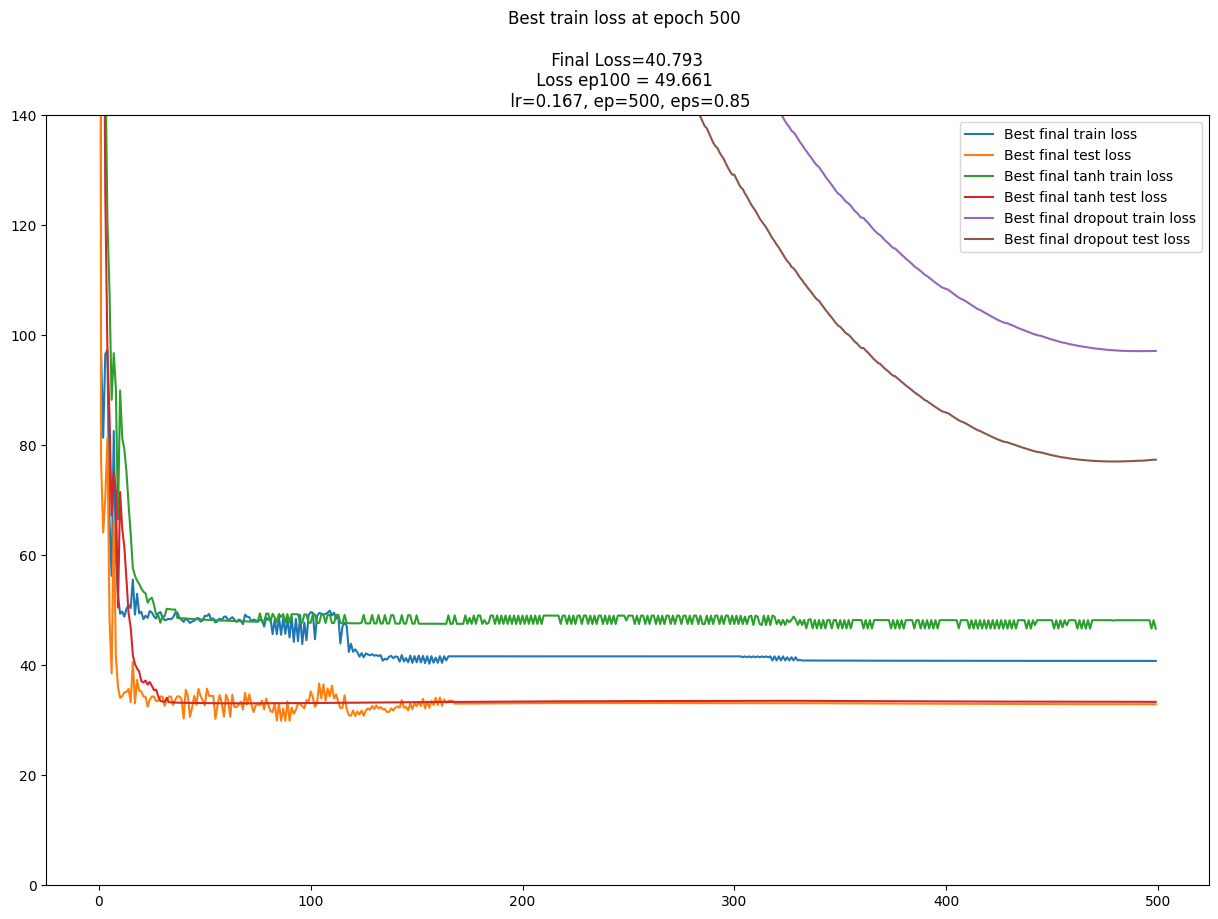

In [223]:
# Min loss for default at epoch 500

(min_lr, min_ep, min_eps), min_train_loss = min(losses['default']['train'].items(), key=lambda x: x[1][-1])
min_test_loss = losses['default']['test'][(min_lr, min_ep, min_eps)]

(min_tanh_lr, min_tanh_ep, min_tanh_eps), min_tanh_train_loss = min(losses['tanh']['train'].items(), key=lambda x: x[1][-1])
min_tanh_test_loss = losses['tanh']['test'][(min_tanh_lr, min_tanh_ep, min_tanh_eps)]

(min_dropout_lr, min_dropout_ep, min_dropout_eps), min_dropout_train_loss = min(less_dropout_train_loss.items(), key=lambda x: x[1][-1])
min_dropout_test_loss = less_dropout_test_loss[(min_dropout_lr, min_dropout_ep, min_dropout_eps)]

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(min_train_loss, label=f'Best final train loss')
ax.plot(min_test_loss, label=f'Best final test loss')

ax.plot(min_tanh_train_loss, label=f'Best final tanh train loss')
ax.plot(min_tanh_test_loss, label=f'Best final tanh test loss')

ax.plot(min_dropout_train_loss, label=f'Best final dropout train loss')
ax.plot(min_dropout_test_loss, label=f'Best final dropout test loss')

ax.set_title(f'Best train loss at epoch 500 \n\n Final Loss={min_train_loss[-1].round(3)[0]} \n Loss ep100 = {min_train_loss[100].round(3)[0]}  \n lr={min_lr}, ep={min_ep}, eps={min_eps}')

ax.legend()

ax.set_ylim(0, 140)

In [225]:
values_df = pd.DataFrame({
    'learning rate': [min_lr, min_tanh_lr, min_dropout_lr],
    'epsilon': [min_eps, min_tanh_eps, min_dropout_eps],
    'epochs': [min_ep, min_tanh_ep, min_dropout_ep],
    'train_loss': [min_train_loss[-1].round(3)[0], min_tanh_train_loss[-1].round(3)[0], min_dropout_train_loss[-1].round(3)[0]],
    'test_loss': [min_test_loss[-1].round(3)[0], min_tanh_test_loss[-1].round(3)[0], min_dropout_test_loss[-1].round(3)[0]],
    'train_loss_ep100': [min_train_loss[100].round(3)[0], min_tanh_train_loss[100].round(3)[0], min_dropout_train_loss[100].round(3)[0]],
    'test_loss_ep100': [min_test_loss[100].round(3)[0], min_tanh_test_loss[100].round(3)[0], min_dropout_test_loss[100].round(3)[0]],
}, index=['default', 'tanh', 'dropout'])

values_df

learning rate                epsilon  epochs  \
default 0.16700000000000000955 0.84999999999999997780     500   
tanh    0.05600000000000000117 0.65000000000000002220     500   
dropout 0.00100000000000000002 0.69999999999999995559     500   

                     train_loss               test_loss  \
default 40.79299999999999926104 32.90899999999999891998   
tanh    46.67099999999999937472 33.34599999999999653255   
dropout 97.15600000000000591172 77.38200000000000500222   

                train_loss_ep100          test_loss_ep100  
default  49.66100000000000136424  35.26100000000000278533  
tanh     47.72599999999999909051  33.13499999999999801048  
dropout 428.01699999999999590727 394.21499999999997498890

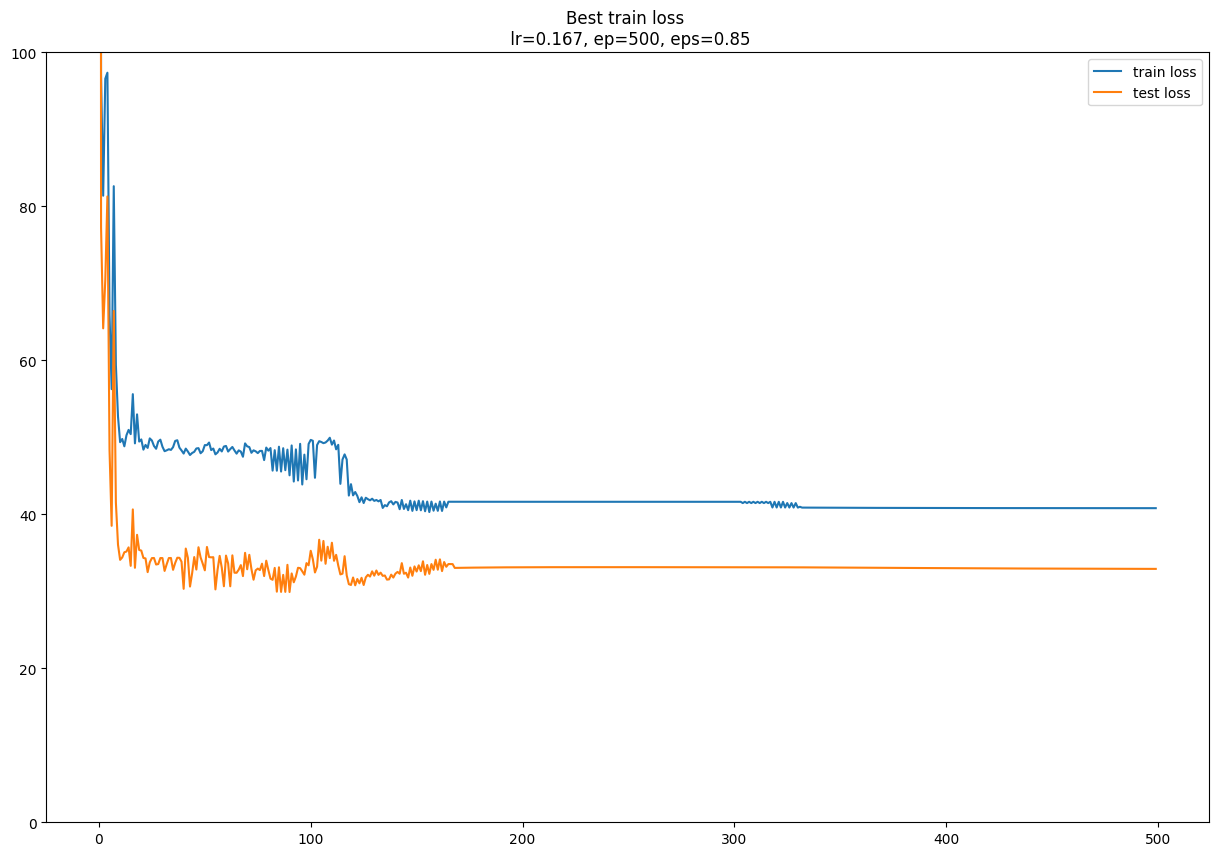

In [351]:
# Plot Min Train Loss 

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(min_train_loss, label=f'train loss')
ax.plot(min_test_loss, label=f'test loss')
_ = ax.set_title(f'Best train loss \n lr={min_lr}, ep={min_ep}, eps={min_eps}')
_ = ax.legend()
_ = ax.set_ylim(0, 100)

100%|██████████| 400/400 [00:01<00:00, 212.54it/s]


### Final Loss

40.90064149852866

(0.0, 100.0)

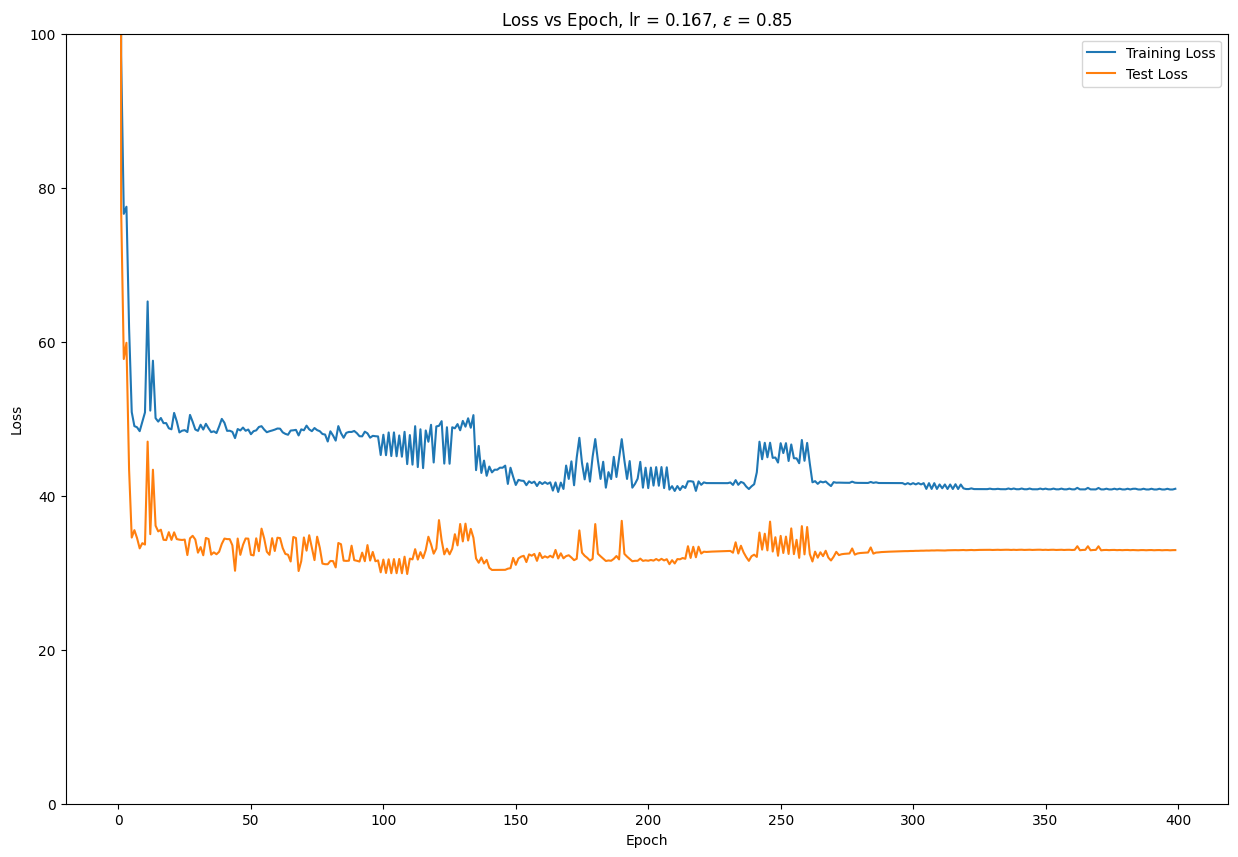

In [362]:
# set numpy seed

np.random.seed(31)

nn_final = NeuralNet()
nn_final.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=400, lr=min_lr, eps=min_eps, verbose=True)

display(Markdown("### Final Loss"))
display(nn_final.get_training_loss()[-1][0])
fig, ax = plt.subplots(figsize=(15, 10))
_ = nn_final.plot_loss(ax=ax)
ax.set_ylim(0, 100)

Por último, optamos por testear como funciona la red con los valores normalizados.

In [314]:
# Normalized values
# Concat X and y
# X_matrix and y_matrix

X_matrix_norm = np.concatenate([X_train, X_test])
y_matrix_norm = np.concatenate([y_train, y_test])

# Normalize X and y
X_matrix_norm = (X_matrix_norm - X_matrix_norm.mean(axis=0)) / X_matrix_norm.std(axis=0)
y_matrix_norm = (y_matrix_norm - y_matrix_norm.mean(axis=0)) / y_matrix_norm.std(axis=0)

# Split X and y
X_train_norm = X_matrix_norm[:X_train.shape[0]]
X_test_norm = X_matrix_norm[X_train.shape[0]:]

y_train_norm = y_matrix_norm[:y_train.shape[0]]
y_test_norm = y_matrix_norm[y_train.shape[0]:]

100%|██████████| 1000/1000 [00:04<00:00, 222.24it/s]


### Final Loss

0.17136768090385895

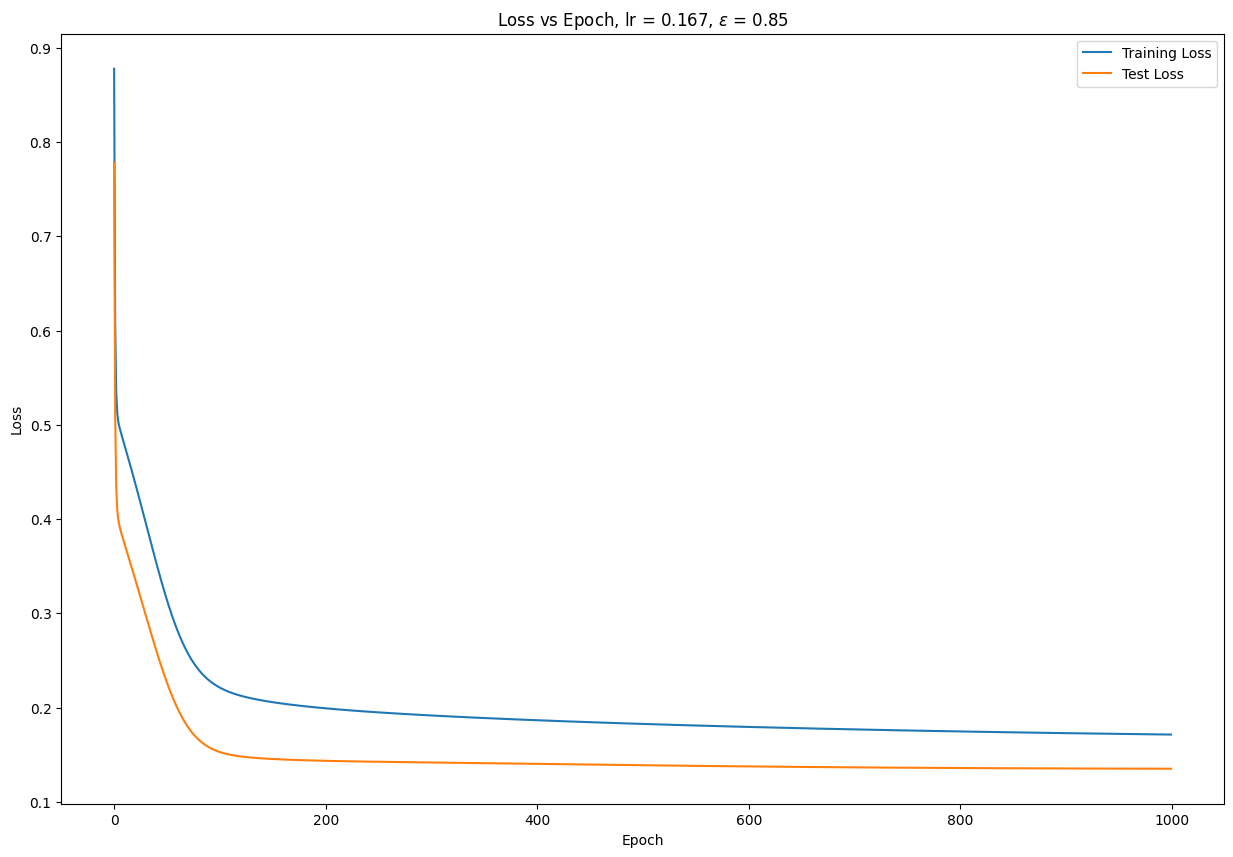

In [367]:
np.random.seed(31)
nn_final_norm = NeuralNet()
nn_final_norm.fit(X_train_norm, y_train_norm, x_test=X_test_norm, y_test=y_test_norm, epochs=1000, lr=min_lr, eps=min_eps, verbose=True)

display(Markdown("### Final Loss"))
display(nn_final_norm.get_training_loss()[-1][0])
fig, ax = plt.subplots(figsize=(15, 10))
_ = nn_final_norm.plot_loss(ax=ax)

## Conclusiones

En este trabajo práctico pudimos ver como el gradiente descendente nos permite entrenar una red neuronal. Pudimos ver como la función de activación sigmoide es la mas adecuada para este tipo de problemas, y como el learning rate y la cantidad de epochs afectan la convergencia de la red.

También pudimos ver como la mascara de pesos no es una buena opción para este tipo de problemas, ya que no logra converger a una loss minima menor que la obtenida sin aplicar la mascara.